([<matplotlib.axis.XTick at 0x11fbe2240>,
 <a list of 3 Text xticklabel objects>)

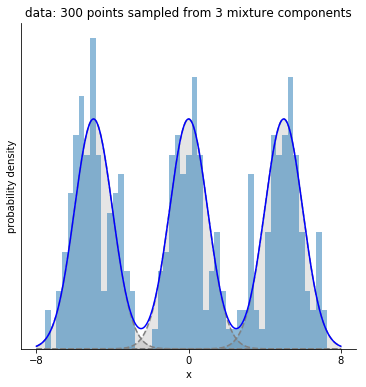

In [1]:
# RJMC for GMMs:
import matplotlib.pyplot as plt
%matplotlib inline

from autograd import numpy as np
np.random.seed(0)
from scipy.stats import norm
from scipy.stats import dirichlet
from scipy.special import logsumexp

def gaussian_mixture_log_likelihood(X, means, stdevs, weights):
    component_log_pdfs = np.array([norm.logpdf(X, loc=mean, scale=stdev) + np.log(weight) for ((mean, stdev), weight) in zip(zip(means, stdevs), weights)])
    return np.sum(logsumexp(component_log_pdfs, 0))

from scipy.stats import norm, invgamma
from scipy.special import logsumexp

def unpack(theta):
    assert(len(theta) % 3 == 0)
    n = int(len(theta) / 3)
    means, stdevs, weights = np.array(theta[:n]), np.array(theta[n:2*n]), np.array(theta[2*n:])
    return means, stdevs, weights

def log_prior(theta):
    means, stdevs, weights = unpack(theta)
    log_prior_on_means = np.sum(norm.logpdf(means, scale=20))
    log_prior_on_variances = np.sum(invgamma.logpdf((stdevs**2), 1.0))
    #log_prior_on_weights = dirichlet.logpdf(weights, np.ones(len(weights)))
    #log_prior_on_weights = np.sum(np.log(weights))
    log_prior_on_weights = 0 # removing the prior on weights to see if this is the culprit...
    return log_prior_on_means + log_prior_on_variances + log_prior_on_weights

def flat_log_p(theta):
    means, stdevs, weights = unpack(theta)
    if np.min(stdevs) <= 0.001: return - np.inf
    log_likelihood = gaussian_mixture_log_likelihood(X=data, means=means,
                                           stdevs=stdevs,
                                           weights=weights)
    
    return log_likelihood + log_prior(theta)

#n_components = 10
#true_means = np.random.rand(n_components) * 10 - 5
#true_stdevs = np.random.rand(n_components) * 0.2
#true_weights = np.random.rand(n_components)**2
#true_weights /= np.sum(true_weights)

n_data = 300
data = np.zeros(n_data)
#for i in range(n_data):
#    component = np.random.choice(np.arange(n_components), p=true_weights)
#    #component = np.random.randint(n_components)
#    data[i] = norm.rvs(loc=true_means[component], scale=true_stdevs[component])

n_components = 3
true_means = [-5.0,0.0,5.0]
true_stdevs = np.ones(n_components)
true_weights = np.ones(n_components) / n_components
n_data = 300
data = np.zeros(n_data)
for i in range(n_data):
    component = np.random.randint(n_components)
    data[i] = norm.rvs(loc=true_means[component], scale=true_stdevs[component])


plt.figure(figsize=(6,6))

ax = plt.subplot(111)
    
plt.hist(data, bins=50, normed=True, alpha=0.5);
x = np.linspace(-8,8, 1000)
y_tot = np.zeros(x.shape)
for i in range(n_components):
    
    y = norm.pdf(x, loc=true_means[i], scale=true_stdevs[i]) * true_weights[i]
    plt.plot(x, y, '--', color='grey',)
    plt.fill_between(x, y, color='grey' ,alpha=0.2)
    y_tot += y
plt.plot(x,y_tot, color='blue',)
plt.yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("data: {} points sampled from {} mixture components".format(n_data, n_components))
plt.ylabel('probability density')
plt.xlabel('x')
plt.xticks([-8,0,8])

In [2]:
np.mean(data), np.std(data)

(-0.2432734349279617, 4.293462995108555)

In [3]:
max_components = 50
mean_perturbation_scale = 1.0
stdev_perturbation_scale = 1.0

def reversible_birth_death_move(theta, parents):
    
    means, stdevs, weights = unpack(theta)
    means, stdevs, weights = map(np.array, (means, stdevs, weights))
    
    sum_weights_before = np.sum(weights)
    n_components = len(means)
    
    # decide whether to create a new 
    if n_components == 1:
        birth_probability = 1.0
    elif n_components == max_components:
        birth_probability = 0.0
    else:
        birth_probability = 0.5
    death_probability = 1.0 - birth_probability
    
    if np.random.rand() < birth_probability:
        (means, stdevs, weights, parents_prime), log_jac_u_term = reversible_birth_move(means, stdevs, weights, parents)
    else:
        (means, stdevs, weights, parents_prime), log_jac_u_term = reversible_death_move(means, stdevs, weights, parents)
    assert(len(means) == len(stdevs))
    theta_prime = np.array(means + stdevs + weights)
    
    sum_weights_after = np.sum(weights)
    assert(np.isclose(sum_weights_before, sum_weights_after))
    return theta_prime, parents_prime, log_jac_u_term
    
from scipy.stats import uniform, norm
u_1_distribution = uniform(0, 1)
u_2_distribution = norm(0, 1)
u_3_distribution = norm(0, 1)


def reversible_birth_move(means, stdevs, weights, parents):
    # make local copies to be extra sure we're not accidentally overwriting...
    means, stdevs, weights, parents = map(list, (means, stdevs, weights, parents))
    
    # draw all the random numbers we're going to use
    i = np.random.randint(len(means)) # choose a parent component at random
    u_1 = u_1_distribution.rvs()
    u_2 = u_2_distribution.rvs()
    u_3 = u_3_distribution.rvs()
    
    # compute the log probability density of all the random numbers we drew
    log_prob_u = np.log(1.0 / len(means)) + u_1_distribution.logpdf(u_1) + u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    # compute the parameters of the new mixture component
    weight_new = weights[i] * u_1
    mean_new = (u_2 * mean_perturbation_scale) + means[i]
    stdev_new = (u_3 * stdev_perturbation_scale) + stdevs[i]
    
    # compute log determinant of the jacobian
    log_jacobian_determinant = np.log(weights[i]) + np.log(mean_perturbation_scale) + np.log(stdev_perturbation_scale)
    
    # subtract the new mixture component's weight from its parent
    weights[i] -= weight_new
    
    # update means, stdevs, weights, parents
    means.append(mean_new)
    stdevs.append(stdev_new)
    weights.append(weight_new)
    parents.append(i)
    
    return (means, stdevs, weights, parents), (log_jacobian_determinant - log_prob_u)
    
def reversible_death_move(means, stdevs, weights, parents):
    # make local copies to be extra sure we're not accidentally overwriting...
    means, stdevs, weights, parents = map(list, (means, stdevs, weights, parents))
    
    # draw all the random numbers we're going to use
    i = np.random.randint(1, len(means)) # choose a component at random to remove, except component 0
    
    # compute the log probability density of all the random numbers we drew
    log_prob_u = np.log(1.0 / (len(means) - 1))
    
    # and also the log probability density of the random numbers we would have drawn?
    weight_new = weights[i]
    mean_new = means[i]
    stdev_new = stdevs[i]
    u_1 = weight_new / weights[parents[i]]
    u_2 = (mean_new - means[parents[i]] ) / mean_perturbation_scale
    u_3 = (stdev_new - stdevs[parents[i]]) / stdev_perturbation_scale
    log_prob_u += u_1_distribution.logpdf(u_1) + u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    # also I think we need to compute the jacobian determinant of the inverse
    inv_log_jacobian_determinant = np.log(weights[parents[i]]) + np.log(mean_perturbation_scale) + np.log(stdev_perturbation_scale)
    log_jacobian_determinant = - inv_log_jacobian_determinant
    
    # remove this mixture component, and re-allocate its weight to its parent
    weights[parents[i]] += weights[i]
    
    # update the parent list, so that any j whose parent just got deleted is assigned a new parent
    for j in range(1, len(parents)):
        if parents[j] == i:
            parents[j] = parents[i]
            
    # wait, this is almost certainly wrong, because the indices will change...
    _ = means.pop(i)
    _ = stdevs.pop(i)
    _ = weights.pop(i)
    _ = parents.pop(i)
    
    # fix indices
    for j in range(1, len(parents)):
        if parents[j] > i:
            parents[j] -= 1
    
    return (means, stdevs, weights, parents), (log_jacobian_determinant - log_prob_u)

from tqdm import tqdm
def rjmcmc_w_parents(theta, parents, n_steps=10000):
    
    traj = [(theta, parents)]
    old_log_p = flat_log_p(theta)
    acceptance_probabilities = []
    
    for t in tqdm(range(n_steps)):
        # generate proposal
        if np.random.rand() < 0.9:
            theta_prime, parents_prime, log_jac_u_term = reversible_birth_death_move(theta, parents)
        else:
            theta_prime = np.array(theta)
            
            n = int(len(theta) / 3)
            
            # different proposal sizes for mean, stdev, weight
            theta_prime[:n] += np.random.randn(n) * 0.1
            theta_prime[n:2*n] += np.random.randn(n) * 0.01
            theta_prime[2*n:] += np.random.randn(n) * 0.01
            
            # make sure the standard deviations are okay
            theta_prime[n:2*n] = np.abs(theta_prime[2*n:])
            
            
            # make sure the weights are okay
            theta_prime[2*n:] = np.abs(theta_prime[2*n:])
            while not np.isclose(np.sum(theta_prime[2*n:]), 1.0):
                theta_prime[2*n:] = theta_prime[2*n:] / np.sum(theta_prime[2*n:])
            #assert(np.max(theta_prime[2*n:]) <= 1)
            #assert(np.max(theta_prime[2*n:]) >= 0)
            #assert(np.sum(theta_prime[2*n:] == 1.0))
            # hacky fix: otherwise this always will raise:
            # ValueError: The input vector 'x' must lie within the normal simplex. but np.sum(x, 0) = 0.946... or similar
            
            # and sometimes also raise:
            #ValueError: Each entry in 'x' must be greater than zero.
            
            parents_prime = parents
            log_jac_u_term = 0.0
           
        
        new_log_p = flat_log_p(theta_prime)
        log_prob_ratio = new_log_p - old_log_p
        if not np.isfinite(new_log_p):
            A = 0
            #print(RuntimeWarning("new_log_p isn't finite: theta = {}, parents = {}".format(theta_prime, parents_prime)))
        else:
            A = min(1.0, np.exp(log_prob_ratio + log_jac_u_term))
    
        if np.random.rand() < A:
            theta = theta_prime
            parents = parents_prime
            old_log_p = new_log_p
            
            if len(theta) != len(traj[-1][0]):
                prev_dim = int(len(traj[-1][0]) / 3)
                current_dim = int(len(theta) / 3)
                assert(len(theta) % 3 == 0)

                print('{}: accepted a cross-model jump! # components: {} --> {}'.format(t, prev_dim, current_dim))
        traj.append((theta, parents))
        acceptance_probabilities.append(A)
    return traj, acceptance_probabilities

In [4]:
np.random.seed(0)
init_n_components = 1
init_means = np.ones(init_n_components) * np.mean(data)
init_stdevs = np.ones(init_n_components) * np.std(data)
init_weights = np.random.rand(init_n_components)
init_weights /= np.sum(init_weights)
init_theta = np.hstack([init_means, init_stdevs, init_weights])
init_parents = [None] + list(range(init_n_components - 1))
traj, acceptance_probabilities = rjmcmc_w_parents(init_theta, init_parents, n_steps=100000)

  0%|          | 336/100000 [00:00<02:00, 829.21it/s]

164: accepted a cross-model jump! # components: 1 --> 2
171: accepted a cross-model jump! # components: 2 --> 1


  2%|▏         | 2214/100000 [00:02<02:02, 799.63it/s]

2124: accepted a cross-model jump! # components: 1 --> 2
2125: accepted a cross-model jump! # components: 2 --> 1


  4%|▍         | 3903/100000 [00:04<02:04, 774.41it/s]

3791: accepted a cross-model jump! # components: 1 --> 2
3792: accepted a cross-model jump! # components: 2 --> 1


  7%|▋         | 7143/100000 [00:08<01:49, 845.27it/s]

6982: accepted a cross-model jump! # components: 1 --> 2
6984: accepted a cross-model jump! # components: 2 --> 1


  8%|▊         | 7562/100000 [00:09<01:52, 819.98it/s]

7416: accepted a cross-model jump! # components: 1 --> 2
7419: accepted a cross-model jump! # components: 2 --> 1
7487: accepted a cross-model jump! # components: 1 --> 2
7490: accepted a cross-model jump! # components: 2 --> 1


 12%|█▏        | 12029/100000 [00:14<01:44, 844.59it/s]

11863: accepted a cross-model jump! # components: 1 --> 2
11865: accepted a cross-model jump! # components: 2 --> 1


 15%|█▌        | 15491/100000 [00:18<01:39, 846.11it/s]

15325: accepted a cross-model jump! # components: 1 --> 2
15326: accepted a cross-model jump! # components: 2 --> 1


 16%|█▌        | 15660/100000 [00:18<01:44, 809.78it/s]

15508: accepted a cross-model jump! # components: 1 --> 2
15510: accepted a cross-model jump! # components: 2 --> 1


 17%|█▋        | 16845/100000 [00:20<01:38, 847.78it/s]

16736: accepted a cross-model jump! # components: 1 --> 2
16738: accepted a cross-model jump! # components: 2 --> 1


 17%|█▋        | 17264/100000 [00:20<01:40, 825.27it/s]

17138: accepted a cross-model jump! # components: 1 --> 2
17141: accepted a cross-model jump! # components: 2 --> 1
17192: accepted a cross-model jump! # components: 1 --> 2
17197: accepted a cross-model jump! # components: 2 --> 1


 20%|█▉        | 19704/100000 [00:23<01:42, 785.03it/s]

19571: accepted a cross-model jump! # components: 1 --> 2
19573: accepted a cross-model jump! # components: 2 --> 1


 24%|██▎       | 23652/100000 [00:28<01:31, 834.87it/s]

23501: accepted a cross-model jump! # components: 1 --> 2
23504: accepted a cross-model jump! # components: 2 --> 1


 24%|██▍       | 23816/100000 [00:28<01:36, 789.58it/s]

23685: accepted a cross-model jump! # components: 1 --> 2
23686: accepted a cross-model jump! # components: 2 --> 1


 25%|██▍       | 24570/100000 [00:29<01:30, 832.80it/s]

24424: accepted a cross-model jump! # components: 1 --> 2
24425: accepted a cross-model jump! # components: 2 --> 1


 25%|██▌       | 25157/100000 [00:30<01:29, 833.28it/s]

24989: accepted a cross-model jump! # components: 1 --> 2
24992: accepted a cross-model jump! # components: 2 --> 1


 25%|██▌       | 25495/100000 [00:31<01:29, 832.55it/s]

25405: accepted a cross-model jump! # components: 1 --> 2
25406: accepted a cross-model jump! # components: 2 --> 1


 28%|██▊       | 28195/100000 [00:34<01:27, 822.66it/s]

28098: accepted a cross-model jump! # components: 1 --> 2
28099: accepted a cross-model jump! # components: 2 --> 1


 29%|██▉       | 29111/100000 [00:35<01:26, 819.86it/s]

28969: accepted a cross-model jump! # components: 1 --> 2
28970: accepted a cross-model jump! # components: 2 --> 1


 31%|███       | 30785/100000 [00:37<01:24, 817.53it/s]

30677: accepted a cross-model jump! # components: 1 --> 2
30679: accepted a cross-model jump! # components: 2 --> 1


 31%|███       | 31117/100000 [00:37<01:25, 805.00it/s]

31031: accepted a cross-model jump! # components: 1 --> 2
31032: accepted a cross-model jump! # components: 2 --> 1


 32%|███▏      | 31536/100000 [00:38<01:22, 826.18it/s]

31416: accepted a cross-model jump! # components: 1 --> 2
31419: accepted a cross-model jump! # components: 2 --> 1


 32%|███▏      | 32445/100000 [00:39<01:23, 813.82it/s]

32295: accepted a cross-model jump! # components: 1 --> 2
32296: accepted a cross-model jump! # components: 2 --> 1


 34%|███▎      | 33701/100000 [00:41<01:21, 808.97it/s]

33597: accepted a cross-model jump! # components: 1 --> 2
33600: accepted a cross-model jump! # components: 2 --> 1


 37%|███▋      | 37477/100000 [00:45<01:17, 811.66it/s]

37354: accepted a cross-model jump! # components: 1 --> 2
37355: accepted a cross-model jump! # components: 2 --> 1


 38%|███▊      | 37640/100000 [00:46<01:18, 797.71it/s]

37558: accepted a cross-model jump! # components: 1 --> 2
37559: accepted a cross-model jump! # components: 2 --> 1


 39%|███▉      | 39274/100000 [00:48<01:20, 749.96it/s]

39198: accepted a cross-model jump! # components: 1 --> 2
39199: accepted a cross-model jump! # components: 2 --> 1


 40%|████      | 40269/100000 [00:49<01:12, 823.52it/s]

40167: accepted a cross-model jump! # components: 1 --> 2
40171: accepted a cross-model jump! # components: 2 --> 1


 46%|████▌     | 45933/100000 [00:56<01:05, 829.35it/s]

45802: accepted a cross-model jump! # components: 1 --> 2
45803: accepted a cross-model jump! # components: 2 --> 1


 47%|████▋     | 47303/100000 [00:57<01:03, 836.38it/s]

47168: accepted a cross-model jump! # components: 1 --> 2
47169: accepted a cross-model jump! # components: 2 --> 1
47333: accepted a cross-model jump! # components: 1 --> 2
47337: accepted a cross-model jump! # components: 2 --> 1

 50%|████▉     | 49701/100000 [01:00<01:00, 828.39it/s]


49566: accepted a cross-model jump! # components: 1 --> 2
49570: accepted a cross-model jump! # components: 2 --> 1


 52%|█████▏    | 51505/100000 [01:02<00:58, 830.35it/s]

51411: accepted a cross-model jump! # components: 1 --> 2
51412: accepted a cross-model jump! # components: 2 --> 1
51537: accepted a cross-model jump! # components: 1 --> 2
51538: accepted a cross-model jump! # components: 2 --> 1


 53%|█████▎    | 52541/100000 [01:03<00:54, 865.91it/s]

52425: accepted a cross-model jump! # components: 1 --> 2
52427: accepted a cross-model jump! # components: 2 --> 1
52545: accepted a cross-model jump! # components: 1 --> 2
52546: accepted a cross-model jump! # components: 2 --> 1


 53%|█████▎    | 53058/100000 [01:04<00:55, 844.36it/s]

52895: accepted a cross-model jump! # components: 1 --> 2
52897: accepted a cross-model jump! # components: 2 --> 1
53063: accepted a cross-model jump! # components: 1 --> 2


 54%|█████▎    | 53568/100000 [01:05<00:55, 833.45it/s]

53064: accepted a cross-model jump! # components: 2 --> 1
53401: accepted a cross-model jump! # components: 1 --> 2
53402: accepted a cross-model jump! # components: 2 --> 1


 54%|█████▍    | 53904/100000 [01:05<00:55, 830.52it/s]

53804: accepted a cross-model jump! # components: 1 --> 2
53805: accepted a cross-model jump! # components: 2 --> 1


 62%|██████▏   | 61675/100000 [01:15<00:48, 792.39it/s]

61577: accepted a cross-model jump! # components: 1 --> 2
61580: accepted a cross-model jump! # components: 2 --> 1


 64%|██████▍   | 64160/100000 [01:18<00:44, 807.06it/s]

64072: accepted a cross-model jump! # components: 1 --> 2
64073: accepted a cross-model jump! # components: 2 --> 1


 65%|██████▍   | 64731/100000 [01:19<00:43, 801.69it/s]

64597: accepted a cross-model jump! # components: 1 --> 2
64600: accepted a cross-model jump! # components: 2 --> 1


 69%|██████▉   | 68833/100000 [01:24<00:39, 789.96it/s]

68714: accepted a cross-model jump! # components: 1 --> 2
68717: accepted a cross-model jump! # components: 2 --> 1


 69%|██████▉   | 69070/100000 [01:24<00:40, 772.08it/s]

68958: accepted a cross-model jump! # components: 1 --> 2
68963: accepted a cross-model jump! # components: 2 --> 1


 70%|███████   | 70267/100000 [01:26<00:39, 756.27it/s]

70194: accepted a cross-model jump! # components: 1 --> 2
70197: accepted a cross-model jump! # components: 2 --> 1


 72%|███████▏  | 72456/100000 [01:28<00:35, 770.43it/s]

72314: accepted a cross-model jump! # components: 1 --> 2
72317: accepted a cross-model jump! # components: 2 --> 1


 75%|███████▌  | 75040/100000 [01:32<00:31, 803.49it/s]

74888: accepted a cross-model jump! # components: 1 --> 2
74890: accepted a cross-model jump! # components: 2 --> 1


 79%|███████▉  | 79079/100000 [01:37<00:28, 733.41it/s]

78975: accepted a cross-model jump! # components: 1 --> 2
78976: accepted a cross-model jump! # components: 2 --> 1


 80%|███████▉  | 79603/100000 [01:38<00:28, 726.56it/s]

79495: accepted a cross-model jump! # components: 1 --> 2
79496: accepted a cross-model jump! # components: 2 --> 1


 85%|████████▌ | 85000/100000 [01:45<00:20, 717.82it/s]

84911: accepted a cross-model jump! # components: 1 --> 2
84913: accepted a cross-model jump! # components: 2 --> 1


 86%|████████▌ | 85641/100000 [01:46<00:20, 693.11it/s]

85507: accepted a cross-model jump! # components: 1 --> 2
85512: accepted a cross-model jump! # components: 2 --> 1


 91%|█████████▏| 91464/100000 [01:55<00:15, 566.55it/s]

91382: accepted a cross-model jump! # components: 1 --> 2
91384: accepted a cross-model jump! # components: 2 --> 1


 92%|█████████▏| 91860/100000 [01:56<00:14, 543.11it/s]

91763: accepted a cross-model jump! # components: 1 --> 2
91765: accepted a cross-model jump! # components: 2 --> 1


 94%|█████████▍| 93759/100000 [01:59<00:10, 623.80it/s]

93665: accepted a cross-model jump! # components: 1 --> 2
93667: accepted a cross-model jump! # components: 2 --> 1


 94%|█████████▍| 93887/100000 [01:59<00:09, 618.51it/s]

93821: accepted a cross-model jump! # components: 1 --> 2
93824: accepted a cross-model jump! # components: 2 --> 1


 95%|█████████▌| 95047/100000 [02:01<00:08, 614.32it/s]

94976: accepted a cross-model jump! # components: 1 --> 2
94984: accepted a cross-model jump! # components: 2 --> 1


 95%|█████████▌| 95371/100000 [02:01<00:07, 605.26it/s]

95323: accepted a cross-model jump! # components: 1 --> 2
95328: accepted a cross-model jump! # components: 2 --> 1


 96%|█████████▋| 96273/100000 [02:03<00:06, 610.00it/s]

96210: accepted a cross-model jump! # components: 1 --> 2
96215: accepted a cross-model jump! # components: 2 --> 1


 98%|█████████▊| 97544/100000 [02:05<00:03, 676.91it/s]

97470: accepted a cross-model jump! # components: 1 --> 2
97472: accepted a cross-model jump! # components: 2 --> 1


 99%|█████████▉| 99166/100000 [02:07<00:01, 689.62it/s]

99027: accepted a cross-model jump! # components: 1 --> 2
99028: accepted a cross-model jump! # components: 2 --> 1


100%|██████████| 100000/100000 [02:08<00:00, 775.87it/s]


In [ ]:
plt.hist(acceptance_probabilities, log=True, bins=50);

In [ ]:
plt.plot([a for a in acceptance_probabilities] )
plt.yscale('log')

In [7]:
traj[0]

(array([-0.24327343,  4.293463  ,  1.        ]), [None])

In [8]:
traj[-1]

(array([-0.24327343,  4.293463  ,  1.        ]), [None])

In [9]:
X = np.vstack([x[0][:2] for x in traj if len(x[0]) == 3])

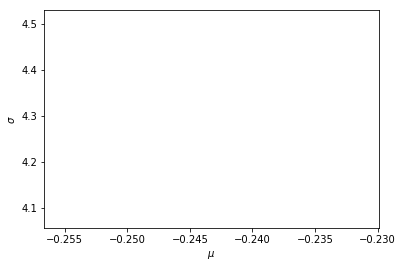

In [10]:
plt.plot(X[:,0], X[:,1], alpha=0.5)


plt.vlines(np.mean(data), min(X[:,1]), max(X[:,1]))
plt.hlines(np.std(data), min(X[:,0]), max(X[:,0]))
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

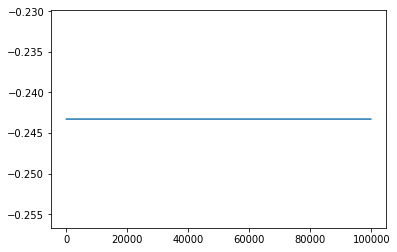

In [11]:
plt.plot(X[:,0])

In [12]:
# okay that looks fine...

In [15]:
np.random.seed(1)
init_n_components = 50
init_means = np.random.randn(init_n_components)
init_stdevs = np.random.rand(init_n_components) + 1
init_weights = np.random.rand(init_n_components)
init_weights /= np.sum(init_weights)
init_theta = np.hstack([init_means, init_stdevs, init_weights])
init_parents = [None] + list(range(init_n_components - 1))
traj, acceptance_probabilities = rjmcmc_w_parents(init_theta, init_parents, n_steps=10000)

  0%|          | 26/10000 [00:00<01:24, 118.17it/s]

0: accepted a cross-model jump! # components: 50 --> 49
3: accepted a cross-model jump! # components: 49 --> 48
4: accepted a cross-model jump! # components: 48 --> 47
6: accepted a cross-model jump! # components: 47 --> 46
7: accepted a cross-model jump! # components: 46 --> 45
8: accepted a cross-model jump! # components: 45 --> 44
9: accepted a cross-model jump! # components: 44 --> 45
11: accepted a cross-model jump! # components: 45 --> 44
14: accepted a cross-model jump! # components: 44 --> 45
15: accepted a cross-model jump! # components: 45 --> 44
18: accepted a cross-model jump! # components: 44 --> 43
19: accepted a cross-model jump! # components: 43 --> 42
21: accepted a cross-model jump! # components: 42 --> 41
22: accepted a cross-model jump! # components: 41 --> 40
23: accepted a cross-model jump! # components: 40 --> 39
24: accepted a cross-model jump! # components: 39 --> 38


  1%|          | 63/10000 [00:00<01:08, 144.29it/s]

27: accepted a cross-model jump! # components: 38 --> 37
28: accepted a cross-model jump! # components: 37 --> 36
29: accepted a cross-model jump! # components: 36 --> 35
31: accepted a cross-model jump! # components: 35 --> 34
32: accepted a cross-model jump! # components: 34 --> 33
34: accepted a cross-model jump! # components: 33 --> 32
35: accepted a cross-model jump! # components: 32 --> 31
37: accepted a cross-model jump! # components: 31 --> 32
39: accepted a cross-model jump! # components: 32 --> 31
41: accepted a cross-model jump! # components: 31 --> 30
42: accepted a cross-model jump! # components: 30 --> 31
43: accepted a cross-model jump! # components: 31 --> 30
48: accepted a cross-model jump! # components: 30 --> 29
50: accepted a cross-model jump! # components: 29 --> 30
53: accepted a cross-model jump! # components: 30 --> 31
56: accepted a cross-model jump! # components: 31 --> 30
61: accepted a cross-model jump! # components: 30 --> 29
62: accepted a cross-model jump

  1%|          | 107/10000 [00:00<00:56, 174.09it/s]

65: accepted a cross-model jump! # components: 28 --> 27
66: accepted a cross-model jump! # components: 27 --> 28
67: accepted a cross-model jump! # components: 28 --> 27
69: accepted a cross-model jump! # components: 27 --> 28
72: accepted a cross-model jump! # components: 28 --> 27
78: accepted a cross-model jump! # components: 27 --> 26
79: accepted a cross-model jump! # components: 26 --> 25
80: accepted a cross-model jump! # components: 25 --> 24
82: accepted a cross-model jump! # components: 24 --> 23
84: accepted a cross-model jump! # components: 23 --> 22
85: accepted a cross-model jump! # components: 22 --> 21
86: accepted a cross-model jump! # components: 21 --> 22
87: accepted a cross-model jump! # components: 22 --> 21
89: accepted a cross-model jump! # components: 21 --> 20
90: accepted a cross-model jump! # components: 20 --> 19
91: accepted a cross-model jump! # components: 19 --> 18
95: accepted a cross-model jump! # components: 18 --> 17
96: accepted a cross-model jump

  2%|▏         | 166/10000 [00:00<00:44, 219.17it/s]

112: accepted a cross-model jump! # components: 17 --> 16
113: accepted a cross-model jump! # components: 16 --> 15
114: accepted a cross-model jump! # components: 15 --> 16
124: accepted a cross-model jump! # components: 16 --> 17
125: accepted a cross-model jump! # components: 17 --> 16
126: accepted a cross-model jump! # components: 16 --> 17
127: accepted a cross-model jump! # components: 17 --> 16
128: accepted a cross-model jump! # components: 16 --> 15
132: accepted a cross-model jump! # components: 15 --> 14
134: accepted a cross-model jump! # components: 14 --> 13
136: accepted a cross-model jump! # components: 13 --> 12
145: accepted a cross-model jump! # components: 12 --> 11
148: accepted a cross-model jump! # components: 11 --> 12
149: accepted a cross-model jump! # components: 12 --> 11
151: accepted a cross-model jump! # components: 11 --> 12
157: accepted a cross-model jump! # components: 12 --> 13
158: accepted a cross-model jump! # components: 13 --> 12
159: accepted 

  3%|▎         | 255/10000 [00:01<00:33, 294.17it/s]

172: accepted a cross-model jump! # components: 12 --> 11
175: accepted a cross-model jump! # components: 11 --> 10
179: accepted a cross-model jump! # components: 10 --> 11
180: accepted a cross-model jump! # components: 11 --> 12
182: accepted a cross-model jump! # components: 12 --> 11
183: accepted a cross-model jump! # components: 11 --> 10
185: accepted a cross-model jump! # components: 10 --> 9
186: accepted a cross-model jump! # components: 9 --> 8
191: accepted a cross-model jump! # components: 8 --> 7
192: accepted a cross-model jump! # components: 7 --> 8
200: accepted a cross-model jump! # components: 8 --> 7
202: accepted a cross-model jump! # components: 7 --> 6
205: accepted a cross-model jump! # components: 6 --> 5
223: accepted a cross-model jump! # components: 5 --> 6
225: accepted a cross-model jump! # components: 6 --> 5
226: accepted a cross-model jump! # components: 5 --> 6
229: accepted a cross-model jump! # components: 6 --> 5
242: accepted a cross-model jump! #

  4%|▎         | 360/10000 [00:01<00:25, 378.95it/s]

269: accepted a cross-model jump! # components: 6 --> 5
270: accepted a cross-model jump! # components: 5 --> 4
276: accepted a cross-model jump! # components: 4 --> 5
279: accepted a cross-model jump! # components: 5 --> 6
284: accepted a cross-model jump! # components: 6 --> 5
286: accepted a cross-model jump! # components: 5 --> 4
287: accepted a cross-model jump! # components: 4 --> 3
288: accepted a cross-model jump! # components: 3 --> 2
290: accepted a cross-model jump! # components: 2 --> 3
293: accepted a cross-model jump! # components: 3 --> 4
294: accepted a cross-model jump! # components: 4 --> 3
296: accepted a cross-model jump! # components: 3 --> 2
297: accepted a cross-model jump! # components: 2 --> 3
298: accepted a cross-model jump! # components: 3 --> 4
300: accepted a cross-model jump! # components: 4 --> 5
302: accepted a cross-model jump! # components: 5 --> 4
303: accepted a cross-model jump! # components: 4 --> 3
313: accepted a cross-model jump! # components: 

  5%|▍         | 471/10000 [00:01<00:21, 451.99it/s]

375: accepted a cross-model jump! # components: 4 --> 5
377: accepted a cross-model jump! # components: 5 --> 6
378: accepted a cross-model jump! # components: 6 --> 5
382: accepted a cross-model jump! # components: 5 --> 6
386: accepted a cross-model jump! # components: 6 --> 5
390: accepted a cross-model jump! # components: 5 --> 4
393: accepted a cross-model jump! # components: 4 --> 5
397: accepted a cross-model jump! # components: 5 --> 4
406: accepted a cross-model jump! # components: 4 --> 5
411: accepted a cross-model jump! # components: 5 --> 6
412: accepted a cross-model jump! # components: 6 --> 5
413: accepted a cross-model jump! # components: 5 --> 4
418: accepted a cross-model jump! # components: 4 --> 3
428: accepted a cross-model jump! # components: 3 --> 4
429: accepted a cross-model jump! # components: 4 --> 5
430: accepted a cross-model jump! # components: 5 --> 6
438: accepted a cross-model jump! # components: 6 --> 7
440: accepted a cross-model jump! # components: 

  6%|▌         | 580/10000 [00:01<00:19, 495.25it/s]

494: accepted a cross-model jump! # components: 7 --> 6
499: accepted a cross-model jump! # components: 6 --> 7
502: accepted a cross-model jump! # components: 7 --> 6
507: accepted a cross-model jump! # components: 6 --> 7
509: accepted a cross-model jump! # components: 7 --> 8
510: accepted a cross-model jump! # components: 8 --> 7
513: accepted a cross-model jump! # components: 7 --> 6
514: accepted a cross-model jump! # components: 6 --> 5
522: accepted a cross-model jump! # components: 5 --> 6
524: accepted a cross-model jump! # components: 6 --> 7
526: accepted a cross-model jump! # components: 7 --> 6
527: accepted a cross-model jump! # components: 6 --> 5
545: accepted a cross-model jump! # components: 5 --> 6
556: accepted a cross-model jump! # components: 6 --> 5
560: accepted a cross-model jump! # components: 5 --> 6
561: accepted a cross-model jump! # components: 6 --> 7
562: accepted a cross-model jump! # components: 7 --> 8
563: accepted a cross-model jump! # components: 

  7%|▋         | 690/10000 [00:01<00:18, 508.76it/s]


604: accepted a cross-model jump! # components: 7 --> 6
605: accepted a cross-model jump! # components: 6 --> 5
606: accepted a cross-model jump! # components: 5 --> 4
607: accepted a cross-model jump! # components: 4 --> 3
610: accepted a cross-model jump! # components: 3 --> 4
612: accepted a cross-model jump! # components: 4 --> 5
613: accepted a cross-model jump! # components: 5 --> 4
619: accepted a cross-model jump! # components: 4 --> 3
620: accepted a cross-model jump! # components: 3 --> 4
621: accepted a cross-model jump! # components: 4 --> 3
624: accepted a cross-model jump! # components: 3 --> 4
634: accepted a cross-model jump! # components: 4 --> 5
635: accepted a cross-model jump! # components: 5 --> 6
639: accepted a cross-model jump! # components: 6 --> 7
641: accepted a cross-model jump! # components: 7 --> 6
642: accepted a cross-model jump! # components: 6 --> 5
644: accepted a cross-model jump! # components: 5 --> 4
645: accepted a cross-model jump! # components:

  8%|▊         | 797/10000 [00:02<00:17, 516.71it/s]

719: accepted a cross-model jump! # components: 5 --> 4
726: accepted a cross-model jump! # components: 4 --> 5
734: accepted a cross-model jump! # components: 5 --> 6
735: accepted a cross-model jump! # components: 6 --> 7
737: accepted a cross-model jump! # components: 7 --> 6
740: accepted a cross-model jump! # components: 6 --> 5
747: accepted a cross-model jump! # components: 5 --> 6
748: accepted a cross-model jump! # components: 6 --> 5
752: accepted a cross-model jump! # components: 5 --> 6
754: accepted a cross-model jump! # components: 6 --> 5
760: accepted a cross-model jump! # components: 5 --> 6
763: accepted a cross-model jump! # components: 6 --> 7
764: accepted a cross-model jump! # components: 7 --> 8
768: accepted a cross-model jump! # components: 8 --> 7
771: accepted a cross-model jump! # components: 7 --> 6
772: accepted a cross-model jump! # components: 6 --> 5
791: accepted a cross-model jump! # components: 5 --> 6
794: accepted a cross-model jump! # components: 

  9%|▉         | 910/10000 [00:02<00:16, 539.96it/s]

827: accepted a cross-model jump! # components: 5 --> 4
831: accepted a cross-model jump! # components: 4 --> 5
832: accepted a cross-model jump! # components: 5 --> 6
835: accepted a cross-model jump! # components: 6 --> 5
837: accepted a cross-model jump! # components: 5 --> 4
848: accepted a cross-model jump! # components: 4 --> 5
849: accepted a cross-model jump! # components: 5 --> 4
850: accepted a cross-model jump! # components: 4 --> 5
851: accepted a cross-model jump! # components: 5 --> 4
855: accepted a cross-model jump! # components: 4 --> 5
863: accepted a cross-model jump! # components: 5 --> 4
873: accepted a cross-model jump! # components: 4 --> 5
876: accepted a cross-model jump! # components: 5 --> 6
881: accepted a cross-model jump! # components: 6 --> 7
882: accepted a cross-model jump! # components: 7 --> 6
883: accepted a cross-model jump! # components: 6 --> 7
886: accepted a cross-model jump! # components: 7 --> 6
888: accepted a cross-model jump! # components: 

 10%|█         | 1024/10000 [00:02<00:17, 525.85it/s]

946: accepted a cross-model jump! # components: 4 --> 5
956: accepted a cross-model jump! # components: 5 --> 4
957: accepted a cross-model jump! # components: 4 --> 5
960: accepted a cross-model jump! # components: 5 --> 6
965: accepted a cross-model jump! # components: 6 --> 7
966: accepted a cross-model jump! # components: 7 --> 6
967: accepted a cross-model jump! # components: 6 --> 5
969: accepted a cross-model jump! # components: 5 --> 4
970: accepted a cross-model jump! # components: 4 --> 5
973: accepted a cross-model jump! # components: 5 --> 4
978: accepted a cross-model jump! # components: 4 --> 5
986: accepted a cross-model jump! # components: 5 --> 6
990: accepted a cross-model jump! # components: 6 --> 7
992: accepted a cross-model jump! # components: 7 --> 6
994: accepted a cross-model jump! # components: 6 --> 5
1001: accepted a cross-model jump! # components: 5 --> 6
1011: accepted a cross-model jump! # components: 6 --> 7
1013: accepted a cross-model jump! # component

 11%|█▏        | 1134/10000 [00:02<00:17, 517.13it/s]

1046: accepted a cross-model jump! # components: 5 --> 6
1047: accepted a cross-model jump! # components: 6 --> 5
1053: accepted a cross-model jump! # components: 5 --> 6
1061: accepted a cross-model jump! # components: 6 --> 5
1063: accepted a cross-model jump! # components: 5 --> 6
1067: accepted a cross-model jump! # components: 6 --> 7
1071: accepted a cross-model jump! # components: 7 --> 6
1073: accepted a cross-model jump! # components: 6 --> 7
1075: accepted a cross-model jump! # components: 7 --> 6
1077: accepted a cross-model jump! # components: 6 --> 5
1088: accepted a cross-model jump! # components: 5 --> 6
1094: accepted a cross-model jump! # components: 6 --> 5
1097: accepted a cross-model jump! # components: 5 --> 4
1119: accepted a cross-model jump! # components: 4 --> 5
1128: accepted a cross-model jump! # components: 5 --> 6
1129: accepted a cross-model jump! # components: 6 --> 5
1133: accepted a cross-model jump! # components: 5 --> 6
1134: accepted a cross-model ju

 12%|█▎        | 1250/10000 [00:02<00:15, 547.25it/s]

1171: accepted a cross-model jump! # components: 5 --> 6
1179: accepted a cross-model jump! # components: 6 --> 5
1189: accepted a cross-model jump! # components: 5 --> 6
1197: accepted a cross-model jump! # components: 6 --> 7
1199: accepted a cross-model jump! # components: 7 --> 6
1200: accepted a cross-model jump! # components: 6 --> 5
1203: accepted a cross-model jump! # components: 5 --> 4
1210: accepted a cross-model jump! # components: 4 --> 5
1222: accepted a cross-model jump! # components: 5 --> 6
1239: accepted a cross-model jump! # components: 6 --> 5
1252: accepted a cross-model jump! # components: 5 --> 6
1261: accepted a cross-model jump! # components: 6 --> 5
1265: accepted a cross-model jump! # components: 5 --> 6
1266: accepted a cross-model jump! # components: 6 --> 7
1267: accepted a cross-model jump! # components: 7 --> 6
1271: accepted a cross-model jump! # components: 6 --> 5


 14%|█▎        | 1364/10000 [00:03<00:15, 552.35it/s]

1302: accepted a cross-model jump! # components: 5 --> 6
1304: accepted a cross-model jump! # components: 6 --> 5
1306: accepted a cross-model jump! # components: 5 --> 6
1307: accepted a cross-model jump! # components: 6 --> 7
1311: accepted a cross-model jump! # components: 7 --> 6
1312: accepted a cross-model jump! # components: 6 --> 5
1313: accepted a cross-model jump! # components: 5 --> 4
1320: accepted a cross-model jump! # components: 4 --> 5
1323: accepted a cross-model jump! # components: 5 --> 4
1333: accepted a cross-model jump! # components: 4 --> 5
1354: accepted a cross-model jump! # components: 5 --> 6
1358: accepted a cross-model jump! # components: 6 --> 5
1361: accepted a cross-model jump! # components: 5 --> 6
1365: accepted a cross-model jump! # components: 6 --> 5
1399: accepted a cross-model jump! # components: 5 --> 6
1403: accepted a cross-model jump! # components: 6 --> 5
1408: accepted a cross-model jump! # components: 5 --> 4


 15%|█▌        | 1533/10000 [00:03<00:15, 548.50it/s]

1428: accepted a cross-model jump! # components: 4 --> 5
1439: accepted a cross-model jump! # components: 5 --> 6
1443: accepted a cross-model jump! # components: 6 --> 5
1444: accepted a cross-model jump! # components: 5 --> 6
1461: accepted a cross-model jump! # components: 6 --> 5
1464: accepted a cross-model jump! # components: 5 --> 4
1468: accepted a cross-model jump! # components: 4 --> 3
1478: accepted a cross-model jump! # components: 3 --> 4
1480: accepted a cross-model jump! # components: 4 --> 3
1481: accepted a cross-model jump! # components: 3 --> 4
1484: accepted a cross-model jump! # components: 4 --> 5
1488: accepted a cross-model jump! # components: 5 --> 4
1497: accepted a cross-model jump! # components: 4 --> 5
1500: accepted a cross-model jump! # components: 5 --> 4
1507: accepted a cross-model jump! # components: 4 --> 5
1509: accepted a cross-model jump! # components: 5 --> 4
1536: accepted a cross-model jump! # components: 4 --> 5


 17%|█▋        | 1658/10000 [00:03<00:14, 582.04it/s]

1540: accepted a cross-model jump! # components: 5 --> 4
1544: accepted a cross-model jump! # components: 4 --> 5
1546: accepted a cross-model jump! # components: 5 --> 4
1563: accepted a cross-model jump! # components: 4 --> 5
1566: accepted a cross-model jump! # components: 5 --> 4
1576: accepted a cross-model jump! # components: 4 --> 5
1578: accepted a cross-model jump! # components: 5 --> 6
1579: accepted a cross-model jump! # components: 6 --> 5
1583: accepted a cross-model jump! # components: 5 --> 6
1584: accepted a cross-model jump! # components: 6 --> 5
1585: accepted a cross-model jump! # components: 5 --> 4
1586: accepted a cross-model jump! # components: 4 --> 5
1593: accepted a cross-model jump! # components: 5 --> 4
1604: accepted a cross-model jump! # components: 4 --> 5
1606: accepted a cross-model jump! # components: 5 --> 4
1609: accepted a cross-model jump! # components: 4 --> 3
1621: accepted a cross-model jump! # components: 3 --> 4
1622: accepted a cross-model ju

 18%|█▊        | 1785/10000 [00:03<00:13, 605.29it/s]

1668: accepted a cross-model jump! # components: 3 --> 4
1672: accepted a cross-model jump! # components: 4 --> 3
1684: accepted a cross-model jump! # components: 3 --> 4
1686: accepted a cross-model jump! # components: 4 --> 5
1687: accepted a cross-model jump! # components: 5 --> 4
1694: accepted a cross-model jump! # components: 4 --> 3
1701: accepted a cross-model jump! # components: 3 --> 4
1709: accepted a cross-model jump! # components: 4 --> 3
1711: accepted a cross-model jump! # components: 3 --> 4
1715: accepted a cross-model jump! # components: 4 --> 5
1716: accepted a cross-model jump! # components: 5 --> 4
1717: accepted a cross-model jump! # components: 4 --> 3
1719: accepted a cross-model jump! # components: 3 --> 2
1722: accepted a cross-model jump! # components: 2 --> 3
1724: accepted a cross-model jump! # components: 3 --> 2
1726: accepted a cross-model jump! # components: 2 --> 3
1727: accepted a cross-model jump! # components: 3 --> 4
1728: accepted a cross-model ju

 19%|█▉        | 1905/10000 [00:04<00:14, 569.85it/s]

1797: accepted a cross-model jump! # components: 4 --> 5
1798: accepted a cross-model jump! # components: 5 --> 4
1803: accepted a cross-model jump! # components: 4 --> 5
1811: accepted a cross-model jump! # components: 5 --> 4
1813: accepted a cross-model jump! # components: 4 --> 5
1825: accepted a cross-model jump! # components: 5 --> 6
1828: accepted a cross-model jump! # components: 6 --> 5
1831: accepted a cross-model jump! # components: 5 --> 6
1832: accepted a cross-model jump! # components: 6 --> 5
1842: accepted a cross-model jump! # components: 5 --> 6
1847: accepted a cross-model jump! # components: 6 --> 5
1849: accepted a cross-model jump! # components: 5 --> 4
1853: accepted a cross-model jump! # components: 4 --> 5
1858: accepted a cross-model jump! # components: 5 --> 6
1859: accepted a cross-model jump! # components: 6 --> 5
1862: accepted a cross-model jump! # components: 5 --> 4
1863: accepted a cross-model jump! # components: 4 --> 5
1868: accepted a cross-model ju

 20%|█▉        | 1963/10000 [00:04<00:15, 530.54it/s]

1913: accepted a cross-model jump! # components: 4 --> 5
1925: accepted a cross-model jump! # components: 5 --> 4
1942: accepted a cross-model jump! # components: 4 --> 5
1943: accepted a cross-model jump! # components: 5 --> 4
1953: accepted a cross-model jump! # components: 4 --> 5
1958: accepted a cross-model jump! # components: 5 --> 4
1961: accepted a cross-model jump! # components: 4 --> 5
1964: accepted a cross-model jump! # components: 5 --> 4
1967: accepted a cross-model jump! # components: 4 --> 5
1969: accepted a cross-model jump! # components: 5 --> 4
1970: accepted a cross-model jump! # components: 4 --> 5
1971: accepted a cross-model jump! # components: 5 --> 4
1972: accepted a cross-model jump! # components: 4 --> 3
1976: accepted a cross-model jump! # components: 3 --> 4
1978: accepted a cross-model jump! # components: 4 --> 3
1982: accepted a cross-model jump! # components: 3 --> 4
1987: accepted a cross-model jump! # components: 4 --> 5
1988: accepted a cross-model ju

 21%|██        | 2066/10000 [00:04<00:17, 459.12it/s]

1997: accepted a cross-model jump! # components: 4 --> 5
1998: accepted a cross-model jump! # components: 5 --> 4
2000: accepted a cross-model jump! # components: 4 --> 5
2001: accepted a cross-model jump! # components: 5 --> 6
2007: accepted a cross-model jump! # components: 6 --> 5
2008: accepted a cross-model jump! # components: 5 --> 4
2009: accepted a cross-model jump! # components: 4 --> 5
2020: accepted a cross-model jump! # components: 5 --> 6
2022: accepted a cross-model jump! # components: 6 --> 5
2026: accepted a cross-model jump! # components: 5 --> 6
2029: accepted a cross-model jump! # components: 6 --> 5
2033: accepted a cross-model jump! # components: 5 --> 4
2056: accepted a cross-model jump! # components: 4 --> 5
2058: accepted a cross-model jump! # components: 5 --> 4
2059: accepted a cross-model jump! # components: 4 --> 3
2072: accepted a cross-model jump! # components: 3 --> 4


 22%|██▏       | 2173/10000 [00:04<00:16, 478.88it/s]

2088: accepted a cross-model jump! # components: 4 --> 3
2089: accepted a cross-model jump! # components: 3 --> 4
2090: accepted a cross-model jump! # components: 4 --> 3
2093: accepted a cross-model jump! # components: 3 --> 4
2094: accepted a cross-model jump! # components: 4 --> 5
2096: accepted a cross-model jump! # components: 5 --> 4
2099: accepted a cross-model jump! # components: 4 --> 5
2100: accepted a cross-model jump! # components: 5 --> 6
2101: accepted a cross-model jump! # components: 6 --> 5
2102: accepted a cross-model jump! # components: 5 --> 4
2106: accepted a cross-model jump! # components: 4 --> 5
2113: accepted a cross-model jump! # components: 5 --> 4
2114: accepted a cross-model jump! # components: 4 --> 3
2150: accepted a cross-model jump! # components: 3 --> 4
2154: accepted a cross-model jump! # components: 4 --> 5
2157: accepted a cross-model jump! # components: 5 --> 4
2158: accepted a cross-model jump! # components: 4 --> 3
2166: accepted a cross-model ju

 23%|██▎       | 2276/10000 [00:04<00:16, 472.57it/s]

2191: accepted a cross-model jump! # components: 4 --> 3
2192: accepted a cross-model jump! # components: 3 --> 2
2196: accepted a cross-model jump! # components: 2 --> 3
2200: accepted a cross-model jump! # components: 3 --> 4
2205: accepted a cross-model jump! # components: 4 --> 3
2206: accepted a cross-model jump! # components: 3 --> 2
2211: accepted a cross-model jump! # components: 2 --> 3
2214: accepted a cross-model jump! # components: 3 --> 2
2225: accepted a cross-model jump! # components: 2 --> 3
2226: accepted a cross-model jump! # components: 3 --> 4
2227: accepted a cross-model jump! # components: 4 --> 3
2228: accepted a cross-model jump! # components: 3 --> 2
2245: accepted a cross-model jump! # components: 2 --> 3
2247: accepted a cross-model jump! # components: 3 --> 2
2249: accepted a cross-model jump! # components: 2 --> 3
2256: accepted a cross-model jump! # components: 3 --> 2
2269: accepted a cross-model jump! # components: 2 --> 3
2271: accepted a cross-model ju

 23%|██▎       | 2325/10000 [00:04<00:18, 425.29it/s]

2286: accepted a cross-model jump! # components: 3 --> 2
2287: accepted a cross-model jump! # components: 2 --> 3
2288: accepted a cross-model jump! # components: 3 --> 2
2293: accepted a cross-model jump! # components: 2 --> 3
2297: accepted a cross-model jump! # components: 3 --> 4
2299: accepted a cross-model jump! # components: 4 --> 3
2301: accepted a cross-model jump! # components: 3 --> 2
2303: accepted a cross-model jump! # components: 2 --> 1
2304: accepted a cross-model jump! # components: 1 --> 2
2305: accepted a cross-model jump! # components: 2 --> 3
2307: accepted a cross-model jump! # components: 3 --> 4
2310: accepted a cross-model jump! # components: 4 --> 5
2313: accepted a cross-model jump! # components: 5 --> 6
2315: accepted a cross-model jump! # components: 6 --> 5
2316: accepted a cross-model jump! # components: 5 --> 4
2317: accepted a cross-model jump! # components: 4 --> 3
2321: accepted a cross-model jump! # components: 3 --> 2
2324: accepted a cross-model ju

 24%|██▍       | 2414/10000 [00:05<00:18, 405.01it/s]


2372: accepted a cross-model jump! # components: 5 --> 4
2381: accepted a cross-model jump! # components: 4 --> 3
2384: accepted a cross-model jump! # components: 3 --> 4
2388: accepted a cross-model jump! # components: 4 --> 5
2389: accepted a cross-model jump! # components: 5 --> 6
2390: accepted a cross-model jump! # components: 6 --> 7
2392: accepted a cross-model jump! # components: 7 --> 6
2393: accepted a cross-model jump! # components: 6 --> 5
2394: accepted a cross-model jump! # components: 5 --> 6
2395: accepted a cross-model jump! # components: 6 --> 5
2400: accepted a cross-model jump! # components: 5 --> 4
2403: accepted a cross-model jump! # components: 4 --> 5
2406: accepted a cross-model jump! # components: 5 --> 4
2407: accepted a cross-model jump! # components: 4 --> 5
2408: accepted a cross-model jump! # components: 5 --> 6
2409: accepted a cross-model jump! # components: 6 --> 7
2410: accepted a cross-model jump! # components: 7 --> 8
2411: accepted a cross-model j

 25%|██▍       | 2499/10000 [00:05<00:18, 405.48it/s]

2454: accepted a cross-model jump! # components: 8 --> 9
2460: accepted a cross-model jump! # components: 9 --> 8
2461: accepted a cross-model jump! # components: 8 --> 7
2464: accepted a cross-model jump! # components: 7 --> 8
2467: accepted a cross-model jump! # components: 8 --> 7
2468: accepted a cross-model jump! # components: 7 --> 6
2471: accepted a cross-model jump! # components: 6 --> 5
2474: accepted a cross-model jump! # components: 5 --> 6
2478: accepted a cross-model jump! # components: 6 --> 5
2496: accepted a cross-model jump! # components: 5 --> 6
2504: accepted a cross-model jump! # components: 6 --> 7
2507: accepted a cross-model jump! # components: 7 --> 6
2508: accepted a cross-model jump! # components: 6 --> 7
2509: accepted a cross-model jump! # components: 7 --> 6
2511: accepted a cross-model jump! # components: 6 --> 5
2517: accepted a cross-model jump! # components: 5 --> 6
2520: accepted a cross-model jump! # components: 6 --> 5
2525: accepted a cross-model ju

 26%|██▋       | 2626/10000 [00:05<00:17, 411.04it/s]

2549: accepted a cross-model jump! # components: 6 --> 5
2552: accepted a cross-model jump! # components: 5 --> 4
2555: accepted a cross-model jump! # components: 4 --> 5
2556: accepted a cross-model jump! # components: 5 --> 6
2558: accepted a cross-model jump! # components: 6 --> 5
2585: accepted a cross-model jump! # components: 5 --> 6
2588: accepted a cross-model jump! # components: 6 --> 5
2601: accepted a cross-model jump! # components: 5 --> 6
2609: accepted a cross-model jump! # components: 6 --> 7
2619: accepted a cross-model jump! # components: 7 --> 6
2625: accepted a cross-model jump! # components: 6 --> 7
2626: accepted a cross-model jump! # components: 7 --> 6
2632: accepted a cross-model jump! # components: 6 --> 5
2633: accepted a cross-model jump! # components: 5 --> 6
2634: accepted a cross-model jump! # components: 6 --> 5


 27%|██▋       | 2712/10000 [00:05<00:17, 412.11it/s]

2638: accepted a cross-model jump! # components: 5 --> 6
2639: accepted a cross-model jump! # components: 6 --> 7
2641: accepted a cross-model jump! # components: 7 --> 6
2644: accepted a cross-model jump! # components: 6 --> 5
2648: accepted a cross-model jump! # components: 5 --> 4
2649: accepted a cross-model jump! # components: 4 --> 5
2652: accepted a cross-model jump! # components: 5 --> 4
2664: accepted a cross-model jump! # components: 4 --> 5
2666: accepted a cross-model jump! # components: 5 --> 4
2695: accepted a cross-model jump! # components: 4 --> 5
2702: accepted a cross-model jump! # components: 5 --> 6
2705: accepted a cross-model jump! # components: 6 --> 5
2708: accepted a cross-model jump! # components: 5 --> 4
2709: accepted a cross-model jump! # components: 4 --> 5
2713: accepted a cross-model jump! # components: 5 --> 6
2717: accepted a cross-model jump! # components: 6 --> 7


 28%|██▊       | 2794/10000 [00:06<00:18, 385.61it/s]

2727: accepted a cross-model jump! # components: 7 --> 6
2730: accepted a cross-model jump! # components: 6 --> 7
2741: accepted a cross-model jump! # components: 7 --> 8
2748: accepted a cross-model jump! # components: 8 --> 7
2749: accepted a cross-model jump! # components: 7 --> 6
2794: accepted a cross-model jump! # components: 6 --> 7
2795: accepted a cross-model jump! # components: 7 --> 8
2797: accepted a cross-model jump! # components: 8 --> 7


 29%|██▉       | 2878/10000 [00:06<00:17, 402.02it/s]

2801: accepted a cross-model jump! # components: 7 --> 6
2802: accepted a cross-model jump! # components: 6 --> 5
2813: accepted a cross-model jump! # components: 5 --> 6
2814: accepted a cross-model jump! # components: 6 --> 7
2815: accepted a cross-model jump! # components: 7 --> 6
2816: accepted a cross-model jump! # components: 6 --> 5
2833: accepted a cross-model jump! # components: 5 --> 6
2834: accepted a cross-model jump! # components: 6 --> 5
2835: accepted a cross-model jump! # components: 5 --> 6
2854: accepted a cross-model jump! # components: 6 --> 5
2880: accepted a cross-model jump! # components: 5 --> 6
2885: accepted a cross-model jump! # components: 6 --> 7


 30%|██▉       | 2961/10000 [00:06<00:17, 398.13it/s]

2886: accepted a cross-model jump! # components: 7 --> 6
2887: accepted a cross-model jump! # components: 6 --> 5
2888: accepted a cross-model jump! # components: 5 --> 4
2889: accepted a cross-model jump! # components: 4 --> 5
2891: accepted a cross-model jump! # components: 5 --> 4
2898: accepted a cross-model jump! # components: 4 --> 5
2924: accepted a cross-model jump! # components: 5 --> 6
2926: accepted a cross-model jump! # components: 6 --> 5
2928: accepted a cross-model jump! # components: 5 --> 6
2937: accepted a cross-model jump! # components: 6 --> 5
2949: accepted a cross-model jump! # components: 5 --> 6
2951: accepted a cross-model jump! # components: 6 --> 7
2952: accepted a cross-model jump! # components: 7 --> 6
2965: accepted a cross-model jump! # components: 6 --> 5
2966: accepted a cross-model jump! # components: 5 --> 6


 30%|███       | 3048/10000 [00:06<00:16, 415.02it/s]

2971: accepted a cross-model jump! # components: 6 --> 7
2973: accepted a cross-model jump! # components: 7 --> 6
2975: accepted a cross-model jump! # components: 6 --> 5
2977: accepted a cross-model jump! # components: 5 --> 4
3013: accepted a cross-model jump! # components: 4 --> 5
3042: accepted a cross-model jump! # components: 5 --> 6
3043: accepted a cross-model jump! # components: 6 --> 7
3046: accepted a cross-model jump! # components: 7 --> 6
3048: accepted a cross-model jump! # components: 6 --> 5
3051: accepted a cross-model jump! # components: 5 --> 4
3059: accepted a cross-model jump! # components: 4 --> 5
3061: accepted a cross-model jump! # components: 5 --> 4


 31%|███▏      | 3137/10000 [00:06<00:16, 426.68it/s]

3062: accepted a cross-model jump! # components: 4 --> 5
3064: accepted a cross-model jump! # components: 5 --> 4
3076: accepted a cross-model jump! # components: 4 --> 5
3080: accepted a cross-model jump! # components: 5 --> 6
3082: accepted a cross-model jump! # components: 6 --> 5
3083: accepted a cross-model jump! # components: 5 --> 4
3086: accepted a cross-model jump! # components: 4 --> 5
3096: accepted a cross-model jump! # components: 5 --> 6
3101: accepted a cross-model jump! # components: 6 --> 5
3106: accepted a cross-model jump! # components: 5 --> 4
3115: accepted a cross-model jump! # components: 4 --> 5
3144: accepted a cross-model jump! # components: 5 --> 6
3145: accepted a cross-model jump! # components: 6 --> 5

 32%|███▏      | 3227/10000 [00:07<00:16, 402.42it/s]


3151: accepted a cross-model jump! # components: 5 --> 6
3156: accepted a cross-model jump! # components: 6 --> 7
3157: accepted a cross-model jump! # components: 7 --> 6
3161: accepted a cross-model jump! # components: 6 --> 5
3169: accepted a cross-model jump! # components: 5 --> 6
3170: accepted a cross-model jump! # components: 6 --> 5
3171: accepted a cross-model jump! # components: 5 --> 6
3173: accepted a cross-model jump! # components: 6 --> 5
3174: accepted a cross-model jump! # components: 5 --> 4
3175: accepted a cross-model jump! # components: 4 --> 3
3204: accepted a cross-model jump! # components: 3 --> 4
3219: accepted a cross-model jump! # components: 4 --> 5
3222: accepted a cross-model jump! # components: 5 --> 6
3223: accepted a cross-model jump! # components: 6 --> 5
3227: accepted a cross-model jump! # components: 5 --> 6


 33%|███▎      | 3314/10000 [00:07<00:16, 410.50it/s]

3233: accepted a cross-model jump! # components: 6 --> 5
3235: accepted a cross-model jump! # components: 5 --> 4
3248: accepted a cross-model jump! # components: 4 --> 5
3255: accepted a cross-model jump! # components: 5 --> 4
3260: accepted a cross-model jump! # components: 4 --> 5
3262: accepted a cross-model jump! # components: 5 --> 4
3263: accepted a cross-model jump! # components: 4 --> 5
3267: accepted a cross-model jump! # components: 5 --> 6
3271: accepted a cross-model jump! # components: 6 --> 5
3277: accepted a cross-model jump! # components: 5 --> 6
3278: accepted a cross-model jump! # components: 6 --> 5
3283: accepted a cross-model jump! # components: 5 --> 4
3295: accepted a cross-model jump! # components: 4 --> 5
3296: accepted a cross-model jump! # components: 5 --> 4
3308: accepted a cross-model jump! # components: 4 --> 5
3309: accepted a cross-model jump! # components: 5 --> 4
3311: accepted a cross-model jump! # components: 4 --> 5


 34%|███▎      | 3356/10000 [00:07<00:17, 381.13it/s]

3324: accepted a cross-model jump! # components: 5 --> 4
3325: accepted a cross-model jump! # components: 4 --> 5
3326: accepted a cross-model jump! # components: 5 --> 4
3334: accepted a cross-model jump! # components: 4 --> 5
3335: accepted a cross-model jump! # components: 5 --> 4
3340: accepted a cross-model jump! # components: 4 --> 5
3349: accepted a cross-model jump! # components: 5 --> 4
3351: accepted a cross-model jump! # components: 4 --> 5
3352: accepted a cross-model jump! # components: 5 --> 4
3358: accepted a cross-model jump! # components: 4 --> 5
3362: accepted a cross-model jump! # components: 5 --> 4
3369: accepted a cross-model jump! # components: 4 --> 5
3371: accepted a cross-model jump! # components: 5 --> 6
3373: accepted a cross-model jump! # components: 6 --> 5


 34%|███▍      | 3442/10000 [00:07<00:17, 370.06it/s]

3382: accepted a cross-model jump! # components: 5 --> 4
3384: accepted a cross-model jump! # components: 4 --> 3
3389: accepted a cross-model jump! # components: 3 --> 4
3390: accepted a cross-model jump! # components: 4 --> 3
3391: accepted a cross-model jump! # components: 3 --> 4
3400: accepted a cross-model jump! # components: 4 --> 3
3440: accepted a cross-model jump! # components: 3 --> 4
3442: accepted a cross-model jump! # components: 4 --> 5
3443: accepted a cross-model jump! # components: 5 --> 6
3444: accepted a cross-model jump! # components: 6 --> 5
3445: accepted a cross-model jump! # components: 5 --> 4
3456: accepted a cross-model jump! # components: 4 --> 5
3458: accepted a cross-model jump! # components: 5 --> 4


 35%|███▌      | 3527/10000 [00:08<00:16, 396.07it/s]

3471: accepted a cross-model jump! # components: 4 --> 5
3472: accepted a cross-model jump! # components: 5 --> 4
3473: accepted a cross-model jump! # components: 4 --> 3
3489: accepted a cross-model jump! # components: 3 --> 4
3550: accepted a cross-model jump! # components: 4 --> 5
3551: accepted a cross-model jump! # components: 5 --> 6
3554: accepted a cross-model jump! # components: 6 --> 5
3556: accepted a cross-model jump! # components: 5 --> 6


 36%|███▌      | 3610/10000 [00:08<00:16, 399.25it/s]

3562: accepted a cross-model jump! # components: 6 --> 5
3568: accepted a cross-model jump! # components: 5 --> 4
3576: accepted a cross-model jump! # components: 4 --> 5
3578: accepted a cross-model jump! # components: 5 --> 4
3579: accepted a cross-model jump! # components: 4 --> 5
3580: accepted a cross-model jump! # components: 5 --> 4
3582: accepted a cross-model jump! # components: 4 --> 3
3583: accepted a cross-model jump! # components: 3 --> 4
3584: accepted a cross-model jump! # components: 4 --> 3
3585: accepted a cross-model jump! # components: 3 --> 4
3586: accepted a cross-model jump! # components: 4 --> 3
3594: accepted a cross-model jump! # components: 3 --> 4
3595: accepted a cross-model jump! # components: 4 --> 5
3597: accepted a cross-model jump! # components: 5 --> 4
3598: accepted a cross-model jump! # components: 4 --> 3
3612: accepted a cross-model jump! # components: 3 --> 4
3620: accepted a cross-model jump! # components: 4 --> 5
3622: accepted a cross-model ju

 37%|███▋      | 3692/10000 [00:08<00:15, 403.35it/s]

3644: accepted a cross-model jump! # components: 4 --> 3
3660: accepted a cross-model jump! # components: 3 --> 4
3661: accepted a cross-model jump! # components: 4 --> 5
3669: accepted a cross-model jump! # components: 5 --> 4
3670: accepted a cross-model jump! # components: 4 --> 5
3672: accepted a cross-model jump! # components: 5 --> 4
3683: accepted a cross-model jump! # components: 4 --> 5
3686: accepted a cross-model jump! # components: 5 --> 4
3689: accepted a cross-model jump! # components: 4 --> 5
3694: accepted a cross-model jump! # components: 5 --> 4
3701: accepted a cross-model jump! # components: 4 --> 5
3702: accepted a cross-model jump! # components: 5 --> 4
3703: accepted a cross-model jump! # components: 4 --> 3
3704: accepted a cross-model jump! # components: 3 --> 2
3716: accepted a cross-model jump! # components: 2 --> 3
3718: accepted a cross-model jump! # components: 3 --> 4
3720: accepted a cross-model jump! # components: 4 --> 5
3724: accepted a cross-model ju

 38%|███▊      | 3778/10000 [00:08<00:15, 403.80it/s]

3733: accepted a cross-model jump! # components: 4 --> 5
3736: accepted a cross-model jump! # components: 5 --> 4
3741: accepted a cross-model jump! # components: 4 --> 3
3751: accepted a cross-model jump! # components: 3 --> 4
3752: accepted a cross-model jump! # components: 4 --> 3
3756: accepted a cross-model jump! # components: 3 --> 4
3759: accepted a cross-model jump! # components: 4 --> 5
3761: accepted a cross-model jump! # components: 5 --> 4
3765: accepted a cross-model jump! # components: 4 --> 5
3767: accepted a cross-model jump! # components: 5 --> 6
3770: accepted a cross-model jump! # components: 6 --> 5
3773: accepted a cross-model jump! # components: 5 --> 4
3774: accepted a cross-model jump! # components: 4 --> 3
3778: accepted a cross-model jump! # components: 3 --> 2
3782: accepted a cross-model jump! # components: 2 --> 3
3784: accepted a cross-model jump! # components: 3 --> 4
3785: accepted a cross-model jump! # components: 4 --> 3
3794: accepted a cross-model ju

 39%|███▊      | 3860/10000 [00:08<00:16, 369.99it/s]

3816: accepted a cross-model jump! # components: 4 --> 3
3817: accepted a cross-model jump! # components: 3 --> 4
3821: accepted a cross-model jump! # components: 4 --> 5
3825: accepted a cross-model jump! # components: 5 --> 6
3829: accepted a cross-model jump! # components: 6 --> 5
3831: accepted a cross-model jump! # components: 5 --> 4
3834: accepted a cross-model jump! # components: 4 --> 5
3841: accepted a cross-model jump! # components: 5 --> 4
3848: accepted a cross-model jump! # components: 4 --> 5
3850: accepted a cross-model jump! # components: 5 --> 4
3875: accepted a cross-model jump! # components: 4 --> 5
3876: accepted a cross-model jump! # components: 5 --> 6
3880: accepted a cross-model jump! # components: 6 --> 7


 39%|███▉      | 3939/10000 [00:09<00:16, 376.61it/s]

3884: accepted a cross-model jump! # components: 7 --> 6
3888: accepted a cross-model jump! # components: 6 --> 5
3900: accepted a cross-model jump! # components: 5 --> 4
3908: accepted a cross-model jump! # components: 4 --> 5
3912: accepted a cross-model jump! # components: 5 --> 4
3915: accepted a cross-model jump! # components: 4 --> 5
3916: accepted a cross-model jump! # components: 5 --> 4
3924: accepted a cross-model jump! # components: 4 --> 5
3926: accepted a cross-model jump! # components: 5 --> 6
3927: accepted a cross-model jump! # components: 6 --> 5
3932: accepted a cross-model jump! # components: 5 --> 4
3937: accepted a cross-model jump! # components: 4 --> 5
3940: accepted a cross-model jump! # components: 5 --> 4
3946: accepted a cross-model jump! # components: 4 --> 5
3949: accepted a cross-model jump! # components: 5 --> 4
3959: accepted a cross-model jump! # components: 4 --> 5
3963: accepted a cross-model jump! # components: 5 --> 6

 40%|████      | 4019/10000 [00:09<00:15, 384.11it/s]


3965: accepted a cross-model jump! # components: 6 --> 5
3967: accepted a cross-model jump! # components: 5 --> 4
3974: accepted a cross-model jump! # components: 4 --> 3
3979: accepted a cross-model jump! # components: 3 --> 4
3980: accepted a cross-model jump! # components: 4 --> 3
3986: accepted a cross-model jump! # components: 3 --> 4
3987: accepted a cross-model jump! # components: 4 --> 5
3988: accepted a cross-model jump! # components: 5 --> 4
3990: accepted a cross-model jump! # components: 4 --> 3
4000: accepted a cross-model jump! # components: 3 --> 4
4001: accepted a cross-model jump! # components: 4 --> 3
4006: accepted a cross-model jump! # components: 3 --> 4
4012: accepted a cross-model jump! # components: 4 --> 5
4019: accepted a cross-model jump! # components: 5 --> 4
4020: accepted a cross-model jump! # components: 4 --> 5
4021: accepted a cross-model jump! # components: 5 --> 4
4027: accepted a cross-model jump! # components: 4 --> 5
4030: accepted a cross-model j

 41%|████      | 4098/10000 [00:09<00:15, 380.53it/s]

4056: accepted a cross-model jump! # components: 4 --> 5
4064: accepted a cross-model jump! # components: 5 --> 4
4075: accepted a cross-model jump! # components: 4 --> 5
4076: accepted a cross-model jump! # components: 5 --> 6
4081: accepted a cross-model jump! # components: 6 --> 5
4090: accepted a cross-model jump! # components: 5 --> 6
4091: accepted a cross-model jump! # components: 6 --> 5
4092: accepted a cross-model jump! # components: 5 --> 6
4093: accepted a cross-model jump! # components: 6 --> 5
4103: accepted a cross-model jump! # components: 5 --> 6
4104: accepted a cross-model jump! # components: 6 --> 5
4108: accepted a cross-model jump! # components: 5 --> 6
4110: accepted a cross-model jump! # components: 6 --> 5
4111: accepted a cross-model jump! # components: 5 --> 6
4113: accepted a cross-model jump! # components: 6 --> 5
4115: accepted a cross-model jump! # components: 5 --> 4
4117: accepted a cross-model jump! # components: 4 --> 5
4121: accepted a cross-model ju

 42%|████▏     | 4175/10000 [00:09<00:16, 363.30it/s]

4125: accepted a cross-model jump! # components: 3 --> 4
4126: accepted a cross-model jump! # components: 4 --> 3
4127: accepted a cross-model jump! # components: 3 --> 4
4138: accepted a cross-model jump! # components: 4 --> 3
4163: accepted a cross-model jump! # components: 3 --> 4
4168: accepted a cross-model jump! # components: 4 --> 3
4169: accepted a cross-model jump! # components: 3 --> 4
4172: accepted a cross-model jump! # components: 4 --> 5
4175: accepted a cross-model jump! # components: 5 --> 4
4179: accepted a cross-model jump! # components: 4 --> 5
4180: accepted a cross-model jump! # components: 5 --> 6
4184: accepted a cross-model jump! # components: 6 --> 5
4185: accepted a cross-model jump! # components: 5 --> 6
4190: accepted a cross-model jump! # components: 6 --> 5
4197: accepted a cross-model jump! # components: 5 --> 6
4199: accepted a cross-model jump! # components: 6 --> 5


 42%|████▏     | 4248/10000 [00:09<00:16, 349.41it/s]

4201: accepted a cross-model jump! # components: 5 --> 6
4204: accepted a cross-model jump! # components: 6 --> 5
4213: accepted a cross-model jump! # components: 5 --> 6
4224: accepted a cross-model jump! # components: 6 --> 7
4225: accepted a cross-model jump! # components: 7 --> 6
4226: accepted a cross-model jump! # components: 6 --> 5
4240: accepted a cross-model jump! # components: 5 --> 4
4249: accepted a cross-model jump! # components: 4 --> 5
4252: accepted a cross-model jump! # components: 5 --> 4
4260: accepted a cross-model jump! # components: 4 --> 5


 43%|████▎     | 4322/10000 [00:10<00:16, 352.88it/s]

4273: accepted a cross-model jump! # components: 5 --> 4
4294: accepted a cross-model jump! # components: 4 --> 5
4296: accepted a cross-model jump! # components: 5 --> 4
4299: accepted a cross-model jump! # components: 4 --> 3
4302: accepted a cross-model jump! # components: 3 --> 4
4305: accepted a cross-model jump! # components: 4 --> 5
4306: accepted a cross-model jump! # components: 5 --> 6
4307: accepted a cross-model jump! # components: 6 --> 5
4311: accepted a cross-model jump! # components: 5 --> 6
4312: accepted a cross-model jump! # components: 6 --> 5
4317: accepted a cross-model jump! # components: 5 --> 6
4318: accepted a cross-model jump! # components: 6 --> 5
4319: accepted a cross-model jump! # components: 5 --> 4
4326: accepted a cross-model jump! # components: 4 --> 5
4340: accepted a cross-model jump! # components: 5 --> 4
4344: accepted a cross-model jump! # components: 4 --> 5
4349: accepted a cross-model jump! # components: 5 --> 4

 44%|████▍     | 4399/10000 [00:10<00:15, 364.89it/s]


4360: accepted a cross-model jump! # components: 4 --> 5
4361: accepted a cross-model jump! # components: 5 --> 4
4364: accepted a cross-model jump! # components: 4 --> 3
4365: accepted a cross-model jump! # components: 3 --> 4
4366: accepted a cross-model jump! # components: 4 --> 3
4371: accepted a cross-model jump! # components: 3 --> 4
4373: accepted a cross-model jump! # components: 4 --> 3
4391: accepted a cross-model jump! # components: 3 --> 4
4394: accepted a cross-model jump! # components: 4 --> 5
4403: accepted a cross-model jump! # components: 5 --> 6
4404: accepted a cross-model jump! # components: 6 --> 5
4416: accepted a cross-model jump! # components: 5 --> 4
4417: accepted a cross-model jump! # components: 4 --> 5
4418: accepted a cross-model jump! # components: 5 --> 4
4423: accepted a cross-model jump! # components: 4 --> 3
4428: accepted a cross-model jump! # components: 3 --> 4
4430: accepted a cross-model jump! # components: 4 --> 5


 45%|████▍     | 4471/10000 [00:10<00:16, 334.41it/s]

4432: accepted a cross-model jump! # components: 5 --> 6
4434: accepted a cross-model jump! # components: 6 --> 5
4440: accepted a cross-model jump! # components: 5 --> 4
4441: accepted a cross-model jump! # components: 4 --> 5
4442: accepted a cross-model jump! # components: 5 --> 4
4444: accepted a cross-model jump! # components: 4 --> 3
4449: accepted a cross-model jump! # components: 3 --> 4
4451: accepted a cross-model jump! # components: 4 --> 5
4453: accepted a cross-model jump! # components: 5 --> 6
4454: accepted a cross-model jump! # components: 6 --> 5
4456: accepted a cross-model jump! # components: 5 --> 4
4457: accepted a cross-model jump! # components: 4 --> 5
4458: accepted a cross-model jump! # components: 5 --> 4
4466: accepted a cross-model jump! # components: 4 --> 5
4467: accepted a cross-model jump! # components: 5 --> 6
4468: accepted a cross-model jump! # components: 6 --> 7
4470: accepted a cross-model jump! # components: 7 --> 6
4475: accepted a cross-model ju

 46%|████▌     | 4551/10000 [00:10<00:15, 346.54it/s]


4493: accepted a cross-model jump! # components: 9 --> 10
4495: accepted a cross-model jump! # components: 10 --> 9
4498: accepted a cross-model jump! # components: 9 --> 8
4501: accepted a cross-model jump! # components: 8 --> 7
4502: accepted a cross-model jump! # components: 7 --> 6
4503: accepted a cross-model jump! # components: 6 --> 5
4507: accepted a cross-model jump! # components: 5 --> 6
4509: accepted a cross-model jump! # components: 6 --> 5
4511: accepted a cross-model jump! # components: 5 --> 4
4512: accepted a cross-model jump! # components: 4 --> 3
4518: accepted a cross-model jump! # components: 3 --> 2
4535: accepted a cross-model jump! # components: 2 --> 3
4536: accepted a cross-model jump! # components: 3 --> 2
4537: accepted a cross-model jump! # components: 2 --> 3
4539: accepted a cross-model jump! # components: 3 --> 2
4560: accepted a cross-model jump! # components: 2 --> 3
4562: accepted a cross-model jump! # components: 3 --> 4
4563: accepted a cross-model

 46%|████▋     | 4630/10000 [00:10<00:14, 365.04it/s]


4574: accepted a cross-model jump! # components: 4 --> 5
4576: accepted a cross-model jump! # components: 5 --> 4
4577: accepted a cross-model jump! # components: 4 --> 3
4591: accepted a cross-model jump! # components: 3 --> 4
4597: accepted a cross-model jump! # components: 4 --> 3
4624: accepted a cross-model jump! # components: 3 --> 4
4628: accepted a cross-model jump! # components: 4 --> 5
4630: accepted a cross-model jump! # components: 5 --> 6
4631: accepted a cross-model jump! # components: 6 --> 7
4633: accepted a cross-model jump! # components: 7 --> 6
4634: accepted a cross-model jump! # components: 6 --> 5
4641: accepted a cross-model jump! # components: 5 --> 4
4642: accepted a cross-model jump! # components: 4 --> 5
4643: accepted a cross-model jump! # components: 5 --> 6
4645: accepted a cross-model jump! # components: 6 --> 5
4646: accepted a cross-model jump! # components: 5 --> 4

 47%|████▋     | 4709/10000 [00:11<00:14, 358.59it/s]


4649: accepted a cross-model jump! # components: 4 --> 5
4651: accepted a cross-model jump! # components: 5 --> 4
4652: accepted a cross-model jump! # components: 4 --> 3
4654: accepted a cross-model jump! # components: 3 --> 4
4658: accepted a cross-model jump! # components: 4 --> 3
4664: accepted a cross-model jump! # components: 3 --> 4
4667: accepted a cross-model jump! # components: 4 --> 3
4671: accepted a cross-model jump! # components: 3 --> 4
4672: accepted a cross-model jump! # components: 4 --> 3
4676: accepted a cross-model jump! # components: 3 --> 4
4677: accepted a cross-model jump! # components: 4 --> 3
4682: accepted a cross-model jump! # components: 3 --> 4
4688: accepted a cross-model jump! # components: 4 --> 3
4689: accepted a cross-model jump! # components: 3 --> 2
4697: accepted a cross-model jump! # components: 2 --> 3
4701: accepted a cross-model jump! # components: 3 --> 2
4708: accepted a cross-model jump! # components: 2 --> 3
4712: accepted a cross-model j

 48%|████▊     | 4794/10000 [00:11<00:13, 382.76it/s]


4726: accepted a cross-model jump! # components: 5 --> 6
4729: accepted a cross-model jump! # components: 6 --> 5
4732: accepted a cross-model jump! # components: 5 --> 6
4734: accepted a cross-model jump! # components: 6 --> 5
4735: accepted a cross-model jump! # components: 5 --> 4
4737: accepted a cross-model jump! # components: 4 --> 5
4740: accepted a cross-model jump! # components: 5 --> 4
4741: accepted a cross-model jump! # components: 4 --> 3
4744: accepted a cross-model jump! # components: 3 --> 4
4747: accepted a cross-model jump! # components: 4 --> 3
4769: accepted a cross-model jump! # components: 3 --> 4
4771: accepted a cross-model jump! # components: 4 --> 3
4779: accepted a cross-model jump! # components: 3 --> 4
4783: accepted a cross-model jump! # components: 4 --> 5
4787: accepted a cross-model jump! # components: 5 --> 4
4788: accepted a cross-model jump! # components: 4 --> 3
4804: accepted a cross-model jump! # components: 3 --> 4
4805: accepted a cross-model j

 49%|████▉     | 4880/10000 [00:11<00:12, 404.14it/s]

4814: accepted a cross-model jump! # components: 3 --> 4
4817: accepted a cross-model jump! # components: 4 --> 3
4831: accepted a cross-model jump! # components: 3 --> 4
4834: accepted a cross-model jump! # components: 4 --> 3
4837: accepted a cross-model jump! # components: 3 --> 4
4840: accepted a cross-model jump! # components: 4 --> 3
4849: accepted a cross-model jump! # components: 3 --> 4
4860: accepted a cross-model jump! # components: 4 --> 3
4869: accepted a cross-model jump! # components: 3 --> 4
4871: accepted a cross-model jump! # components: 4 --> 5
4874: accepted a cross-model jump! # components: 5 --> 4
4882: accepted a cross-model jump! # components: 4 --> 5
4884: accepted a cross-model jump! # components: 5 --> 6
4885: accepted a cross-model jump! # components: 6 --> 5
4886: accepted a cross-model jump! # components: 5 --> 4
4887: accepted a cross-model jump! # components: 4 --> 3
4890: accepted a cross-model jump! # components: 3 --> 4
4893: accepted a cross-model ju

 50%|████▉     | 4963/10000 [00:11<00:12, 392.86it/s]

4898: accepted a cross-model jump! # components: 5 --> 4
4899: accepted a cross-model jump! # components: 4 --> 3
4907: accepted a cross-model jump! # components: 3 --> 4
4915: accepted a cross-model jump! # components: 4 --> 3
4921: accepted a cross-model jump! # components: 3 --> 4
4929: accepted a cross-model jump! # components: 4 --> 5
4934: accepted a cross-model jump! # components: 5 --> 4
4950: accepted a cross-model jump! # components: 4 --> 5
4951: accepted a cross-model jump! # components: 5 --> 6
4954: accepted a cross-model jump! # components: 6 --> 5
4955: accepted a cross-model jump! # components: 5 --> 4
4956: accepted a cross-model jump! # components: 4 --> 5
4957: accepted a cross-model jump! # components: 5 --> 6
4958: accepted a cross-model jump! # components: 6 --> 5
4960: accepted a cross-model jump! # components: 5 --> 6
4962: accepted a cross-model jump! # components: 6 --> 7
4963: accepted a cross-model jump! # components: 7 --> 6
4964: accepted a cross-model ju

 50%|█████     | 5046/10000 [00:12<00:12, 385.74it/s]

4977: accepted a cross-model jump! # components: 6 --> 5
4980: accepted a cross-model jump! # components: 5 --> 6
4981: accepted a cross-model jump! # components: 6 --> 5
4984: accepted a cross-model jump! # components: 5 --> 6
4986: accepted a cross-model jump! # components: 6 --> 7
4988: accepted a cross-model jump! # components: 7 --> 6
4989: accepted a cross-model jump! # components: 6 --> 7
4990: accepted a cross-model jump! # components: 7 --> 6
4991: accepted a cross-model jump! # components: 6 --> 5
4992: accepted a cross-model jump! # components: 5 --> 4
4996: accepted a cross-model jump! # components: 4 --> 3
5012: accepted a cross-model jump! # components: 3 --> 4
5014: accepted a cross-model jump! # components: 4 --> 5
5015: accepted a cross-model jump! # components: 5 --> 4
5026: accepted a cross-model jump! # components: 4 --> 5
5029: accepted a cross-model jump! # components: 5 --> 6
5030: accepted a cross-model jump! # components: 6 --> 5
5038: accepted a cross-model ju

 51%|█████     | 5123/10000 [00:12<00:13, 358.18it/s]


5056: accepted a cross-model jump! # components: 5 --> 6
5058: accepted a cross-model jump! # components: 6 --> 5
5059: accepted a cross-model jump! # components: 5 --> 6
5060: accepted a cross-model jump! # components: 6 --> 5
5062: accepted a cross-model jump! # components: 5 --> 4
5069: accepted a cross-model jump! # components: 4 --> 5
5070: accepted a cross-model jump! # components: 5 --> 6
5072: accepted a cross-model jump! # components: 6 --> 5
5073: accepted a cross-model jump! # components: 5 --> 6
5077: accepted a cross-model jump! # components: 6 --> 5
5078: accepted a cross-model jump! # components: 5 --> 6
5079: accepted a cross-model jump! # components: 6 --> 5
5082: accepted a cross-model jump! # components: 5 --> 6
5085: accepted a cross-model jump! # components: 6 --> 5
5088: accepted a cross-model jump! # components: 5 --> 4
5090: accepted a cross-model jump! # components: 4 --> 5
5093: accepted a cross-model jump! # components: 5 --> 4
5098: accepted a cross-model j

 52%|█████▏    | 5207/10000 [00:12<00:12, 382.98it/s]

5135: accepted a cross-model jump! # components: 3 --> 4
5136: accepted a cross-model jump! # components: 4 --> 3
5137: accepted a cross-model jump! # components: 3 --> 4
5139: accepted a cross-model jump! # components: 4 --> 5
5140: accepted a cross-model jump! # components: 5 --> 4
5141: accepted a cross-model jump! # components: 4 --> 3
5144: accepted a cross-model jump! # components: 3 --> 4
5146: accepted a cross-model jump! # components: 4 --> 3
5152: accepted a cross-model jump! # components: 3 --> 4
5162: accepted a cross-model jump! # components: 4 --> 3
5172: accepted a cross-model jump! # components: 3 --> 4
5175: accepted a cross-model jump! # components: 4 --> 3
5182: accepted a cross-model jump! # components: 3 --> 4
5183: accepted a cross-model jump! # components: 4 --> 3
5185: accepted a cross-model jump! # components: 3 --> 4
5192: accepted a cross-model jump! # components: 4 --> 3
5195: accepted a cross-model jump! # components: 3 --> 4
5199: accepted a cross-model ju

 53%|█████▎    | 5283/10000 [00:12<00:13, 342.34it/s]

5225: accepted a cross-model jump! # components: 5 --> 6
5232: accepted a cross-model jump! # components: 6 --> 5
5252: accepted a cross-model jump! # components: 5 --> 6
5253: accepted a cross-model jump! # components: 6 --> 5
5255: accepted a cross-model jump! # components: 5 --> 6
5259: accepted a cross-model jump! # components: 6 --> 5
5262: accepted a cross-model jump! # components: 5 --> 4
5267: accepted a cross-model jump! # components: 4 --> 5
5268: accepted a cross-model jump! # components: 5 --> 4
5269: accepted a cross-model jump! # components: 4 --> 3
5274: accepted a cross-model jump! # components: 3 --> 4
5276: accepted a cross-model jump! # components: 4 --> 5
5277: accepted a cross-model jump! # components: 5 --> 4


 54%|█████▎    | 5357/10000 [00:12<00:13, 349.15it/s]

5286: accepted a cross-model jump! # components: 4 --> 3
5292: accepted a cross-model jump! # components: 3 --> 4
5293: accepted a cross-model jump! # components: 4 --> 5
5295: accepted a cross-model jump! # components: 5 --> 4
5297: accepted a cross-model jump! # components: 4 --> 3
5300: accepted a cross-model jump! # components: 3 --> 4
5301: accepted a cross-model jump! # components: 4 --> 3
5309: accepted a cross-model jump! # components: 3 --> 4
5310: accepted a cross-model jump! # components: 4 --> 3
5311: accepted a cross-model jump! # components: 3 --> 4
5313: accepted a cross-model jump! # components: 4 --> 3
5318: accepted a cross-model jump! # components: 3 --> 4
5327: accepted a cross-model jump! # components: 4 --> 3
5336: accepted a cross-model jump! # components: 3 --> 4
5339: accepted a cross-model jump! # components: 4 --> 5
5340: accepted a cross-model jump! # components: 5 --> 4
5341: accepted a cross-model jump! # components: 4 --> 3
5343: accepted a cross-model ju

 54%|█████▍    | 5428/10000 [00:13<00:13, 334.90it/s]

5372: accepted a cross-model jump! # components: 4 --> 5
5390: accepted a cross-model jump! # components: 5 --> 6
5391: accepted a cross-model jump! # components: 6 --> 7
5397: accepted a cross-model jump! # components: 7 --> 6
5400: accepted a cross-model jump! # components: 6 --> 5
5421: accepted a cross-model jump! # components: 5 --> 6
5422: accepted a cross-model jump! # components: 6 --> 5
5424: accepted a cross-model jump! # components: 5 --> 4
5428: accepted a cross-model jump! # components: 4 --> 5
5430: accepted a cross-model jump! # components: 5 --> 4
5432: accepted a cross-model jump! # components: 4 --> 5
5435: accepted a cross-model jump! # components: 5 --> 6


 55%|█████▌    | 5504/10000 [00:13<00:12, 355.49it/s]

5440: accepted a cross-model jump! # components: 6 --> 7
5441: accepted a cross-model jump! # components: 7 --> 6
5445: accepted a cross-model jump! # components: 6 --> 5
5448: accepted a cross-model jump! # components: 5 --> 4
5462: accepted a cross-model jump! # components: 4 --> 5
5463: accepted a cross-model jump! # components: 5 --> 4
5485: accepted a cross-model jump! # components: 4 --> 5
5488: accepted a cross-model jump! # components: 5 --> 4
5495: accepted a cross-model jump! # components: 4 --> 5
5496: accepted a cross-model jump! # components: 5 --> 4
5507: accepted a cross-model jump! # components: 4 --> 5
5509: accepted a cross-model jump! # components: 5 --> 4
5510: accepted a cross-model jump! # components: 4 --> 5
5512: accepted a cross-model jump! # components: 5 --> 6


 56%|█████▌    | 5574/10000 [00:13<00:13, 326.88it/s]

5515: accepted a cross-model jump! # components: 6 --> 7
5516: accepted a cross-model jump! # components: 7 --> 6
5528: accepted a cross-model jump! # components: 6 --> 5
5534: accepted a cross-model jump! # components: 5 --> 6
5537: accepted a cross-model jump! # components: 6 --> 5
5548: accepted a cross-model jump! # components: 5 --> 6
5552: accepted a cross-model jump! # components: 6 --> 7
5554: accepted a cross-model jump! # components: 7 --> 6
5558: accepted a cross-model jump! # components: 6 --> 5
5581: accepted a cross-model jump! # components: 5 --> 6

 56%|█████▋    | 5646/10000 [00:13<00:12, 342.68it/s]


5582: accepted a cross-model jump! # components: 6 --> 5
5585: accepted a cross-model jump! # components: 5 --> 4
5586: accepted a cross-model jump! # components: 4 --> 3
5589: accepted a cross-model jump! # components: 3 --> 4
5590: accepted a cross-model jump! # components: 4 --> 5
5592: accepted a cross-model jump! # components: 5 --> 4
5596: accepted a cross-model jump! # components: 4 --> 5
5599: accepted a cross-model jump! # components: 5 --> 4
5600: accepted a cross-model jump! # components: 4 --> 3
5607: accepted a cross-model jump! # components: 3 --> 4
5609: accepted a cross-model jump! # components: 4 --> 5
5610: accepted a cross-model jump! # components: 5 --> 4
5614: accepted a cross-model jump! # components: 4 --> 5
5619: accepted a cross-model jump! # components: 5 --> 4
5628: accepted a cross-model jump! # components: 4 --> 5
5629: accepted a cross-model jump! # components: 5 --> 4
5631: accepted a cross-model jump! # components: 4 --> 3
5633: accepted a cross-model j

 57%|█████▋    | 5720/10000 [00:14<00:12, 353.46it/s]

5661: accepted a cross-model jump! # components: 4 --> 3
5663: accepted a cross-model jump! # components: 3 --> 2
5665: accepted a cross-model jump! # components: 2 --> 3
5671: accepted a cross-model jump! # components: 3 --> 4
5678: accepted a cross-model jump! # components: 4 --> 3
5682: accepted a cross-model jump! # components: 3 --> 4
5683: accepted a cross-model jump! # components: 4 --> 3
5684: accepted a cross-model jump! # components: 3 --> 4
5688: accepted a cross-model jump! # components: 4 --> 3
5689: accepted a cross-model jump! # components: 3 --> 2
5690: accepted a cross-model jump! # components: 2 --> 3
5692: accepted a cross-model jump! # components: 3 --> 2
5701: accepted a cross-model jump! # components: 2 --> 3
5702: accepted a cross-model jump! # components: 3 --> 4
5708: accepted a cross-model jump! # components: 4 --> 5
5711: accepted a cross-model jump! # components: 5 --> 6
5716: accepted a cross-model jump! # components: 6 --> 5
5719: accepted a cross-model ju

 58%|█████▊    | 5793/10000 [00:14<00:11, 355.47it/s]

5745: accepted a cross-model jump! # components: 4 --> 5
5746: accepted a cross-model jump! # components: 5 --> 4
5749: accepted a cross-model jump! # components: 4 --> 5
5754: accepted a cross-model jump! # components: 5 --> 4
5763: accepted a cross-model jump! # components: 4 --> 5
5764: accepted a cross-model jump! # components: 5 --> 6
5765: accepted a cross-model jump! # components: 6 --> 5
5791: accepted a cross-model jump! # components: 5 --> 6
5793: accepted a cross-model jump! # components: 6 --> 5
5802: accepted a cross-model jump! # components: 5 --> 6
5809: accepted a cross-model jump! # components: 6 --> 5


 59%|█████▊    | 5870/10000 [00:14<00:11, 360.90it/s]

5826: accepted a cross-model jump! # components: 5 --> 6
5827: accepted a cross-model jump! # components: 6 --> 5
5850: accepted a cross-model jump! # components: 5 --> 6
5851: accepted a cross-model jump! # components: 6 --> 5
5853: accepted a cross-model jump! # components: 5 --> 4
5875: accepted a cross-model jump! # components: 4 --> 5
5876: accepted a cross-model jump! # components: 5 --> 4
5881: accepted a cross-model jump! # components: 4 --> 3
5884: accepted a cross-model jump! # components: 3 --> 4
5888: accepted a cross-model jump! # components: 4 --> 3
5893: accepted a cross-model jump! # components: 3 --> 4
5899: accepted a cross-model jump! # components: 4 --> 3
5902: accepted a cross-model jump! # components: 3 --> 4


 60%|█████▉    | 5954/10000 [00:14<00:10, 382.89it/s]

5913: accepted a cross-model jump! # components: 4 --> 3
5930: accepted a cross-model jump! # components: 3 --> 4
5937: accepted a cross-model jump! # components: 4 --> 5
5939: accepted a cross-model jump! # components: 5 --> 6
5947: accepted a cross-model jump! # components: 6 --> 5
5952: accepted a cross-model jump! # components: 5 --> 4
5953: accepted a cross-model jump! # components: 4 --> 5
5956: accepted a cross-model jump! # components: 5 --> 4
5959: accepted a cross-model jump! # components: 4 --> 5
5961: accepted a cross-model jump! # components: 5 --> 6
5965: accepted a cross-model jump! # components: 6 --> 5
5973: accepted a cross-model jump! # components: 5 --> 6
5974: accepted a cross-model jump! # components: 6 --> 5


 61%|██████    | 6079/10000 [00:14<00:09, 398.36it/s]

6005: accepted a cross-model jump! # components: 5 --> 6
6006: accepted a cross-model jump! # components: 6 --> 5
6008: accepted a cross-model jump! # components: 5 --> 4
6009: accepted a cross-model jump! # components: 4 --> 3
6013: accepted a cross-model jump! # components: 3 --> 4
6016: accepted a cross-model jump! # components: 4 --> 3
6018: accepted a cross-model jump! # components: 3 --> 4
6019: accepted a cross-model jump! # components: 4 --> 3
6037: accepted a cross-model jump! # components: 3 --> 4
6039: accepted a cross-model jump! # components: 4 --> 3
6044: accepted a cross-model jump! # components: 3 --> 2
6047: accepted a cross-model jump! # components: 2 --> 3
6049: accepted a cross-model jump! # components: 3 --> 2
6064: accepted a cross-model jump! # components: 2 --> 3
6067: accepted a cross-model jump! # components: 3 --> 2
6072: accepted a cross-model jump! # components: 2 --> 3
6074: accepted a cross-model jump! # components: 3 --> 4
6075: accepted a cross-model ju

 62%|██████▏   | 6169/10000 [00:15<00:09, 407.27it/s]


6096: accepted a cross-model jump! # components: 4 --> 3
6097: accepted a cross-model jump! # components: 3 --> 2
6098: accepted a cross-model jump! # components: 2 --> 3
6103: accepted a cross-model jump! # components: 3 --> 2
6104: accepted a cross-model jump! # components: 2 --> 1
6106: accepted a cross-model jump! # components: 1 --> 2
6108: accepted a cross-model jump! # components: 2 --> 1
6109: accepted a cross-model jump! # components: 1 --> 2
6121: accepted a cross-model jump! # components: 2 --> 3
6128: accepted a cross-model jump! # components: 3 --> 2
6132: accepted a cross-model jump! # components: 2 --> 3
6133: accepted a cross-model jump! # components: 3 --> 4
6135: accepted a cross-model jump! # components: 4 --> 5
6150: accepted a cross-model jump! # components: 5 --> 6
6151: accepted a cross-model jump! # components: 6 --> 5
6152: accepted a cross-model jump! # components: 5 --> 4
6158: accepted a cross-model jump! # components: 4 --> 5
6159: accepted a cross-model j

 63%|██████▎   | 6251/10000 [00:15<00:09, 391.84it/s]


6184: accepted a cross-model jump! # components: 5 --> 6
6185: accepted a cross-model jump! # components: 6 --> 5
6193: accepted a cross-model jump! # components: 5 --> 6
6195: accepted a cross-model jump! # components: 6 --> 5
6196: accepted a cross-model jump! # components: 5 --> 6
6206: accepted a cross-model jump! # components: 6 --> 7
6209: accepted a cross-model jump! # components: 7 --> 6
6212: accepted a cross-model jump! # components: 6 --> 5
6215: accepted a cross-model jump! # components: 5 --> 6
6216: accepted a cross-model jump! # components: 6 --> 7
6219: accepted a cross-model jump! # components: 7 --> 6
6222: accepted a cross-model jump! # components: 6 --> 5
6226: accepted a cross-model jump! # components: 5 --> 4
6227: accepted a cross-model jump! # components: 4 --> 5
6228: accepted a cross-model jump! # components: 5 --> 4


 63%|██████▎   | 6331/10000 [00:15<00:09, 380.22it/s]

6264: accepted a cross-model jump! # components: 4 --> 5
6265: accepted a cross-model jump! # components: 5 --> 6
6266: accepted a cross-model jump! # components: 6 --> 5
6278: accepted a cross-model jump! # components: 5 --> 6
6282: accepted a cross-model jump! # components: 6 --> 5
6283: accepted a cross-model jump! # components: 5 --> 4
6305: accepted a cross-model jump! # components: 4 --> 5
6328: accepted a cross-model jump! # components: 5 --> 6
6335: accepted a cross-model jump! # components: 6 --> 7


 64%|██████▎   | 6370/10000 [00:15<00:10, 354.85it/s]

6339: accepted a cross-model jump! # components: 7 --> 6
6340: accepted a cross-model jump! # components: 6 --> 5
6341: accepted a cross-model jump! # components: 5 --> 6
6346: accepted a cross-model jump! # components: 6 --> 7
6347: accepted a cross-model jump! # components: 7 --> 6
6349: accepted a cross-model jump! # components: 6 --> 5
6361: accepted a cross-model jump! # components: 5 --> 6
6363: accepted a cross-model jump! # components: 6 --> 5
6368: accepted a cross-model jump! # components: 5 --> 6
6370: accepted a cross-model jump! # components: 6 --> 5
6376: accepted a cross-model jump! # components: 5 --> 6
6378: accepted a cross-model jump! # components: 6 --> 5
6402: accepted a cross-model jump! # components: 5 --> 6


 64%|██████▍   | 6443/10000 [00:15<00:10, 351.28it/s]

6403: accepted a cross-model jump! # components: 6 --> 5
6404: accepted a cross-model jump! # components: 5 --> 4
6420: accepted a cross-model jump! # components: 4 --> 5
6421: accepted a cross-model jump! # components: 5 --> 4
6428: accepted a cross-model jump! # components: 4 --> 5
6429: accepted a cross-model jump! # components: 5 --> 6
6430: accepted a cross-model jump! # components: 6 --> 5
6432: accepted a cross-model jump! # components: 5 --> 6
6433: accepted a cross-model jump! # components: 6 --> 5
6435: accepted a cross-model jump! # components: 5 --> 6
6440: accepted a cross-model jump! # components: 6 --> 5
6441: accepted a cross-model jump! # components: 5 --> 4
6442: accepted a cross-model jump! # components: 4 --> 3
6450: accepted a cross-model jump! # components: 3 --> 4
6451: accepted a cross-model jump! # components: 4 --> 3
6463: accepted a cross-model jump! # components: 3 --> 4
6465: accepted a cross-model jump! # components: 4 --> 3
6483: accepted a cross-model ju

 66%|██████▌   | 6566/10000 [00:16<00:09, 379.31it/s]


6493: accepted a cross-model jump! # components: 3 --> 4
6511: accepted a cross-model jump! # components: 4 --> 5
6515: accepted a cross-model jump! # components: 5 --> 4
6527: accepted a cross-model jump! # components: 4 --> 5
6534: accepted a cross-model jump! # components: 5 --> 4
6539: accepted a cross-model jump! # components: 4 --> 5
6540: accepted a cross-model jump! # components: 5 --> 6
6545: accepted a cross-model jump! # components: 6 --> 5
6546: accepted a cross-model jump! # components: 5 --> 6
6547: accepted a cross-model jump! # components: 6 --> 5
6554: accepted a cross-model jump! # components: 5 --> 6
6555: accepted a cross-model jump! # components: 6 --> 5
6556: accepted a cross-model jump! # components: 5 --> 4


 67%|██████▋   | 6687/10000 [00:16<00:08, 383.39it/s]

6618: accepted a cross-model jump! # components: 4 --> 5
6633: accepted a cross-model jump! # components: 5 --> 6
6635: accepted a cross-model jump! # components: 6 --> 5
6641: accepted a cross-model jump! # components: 5 --> 4
6650: accepted a cross-model jump! # components: 4 --> 5
6656: accepted a cross-model jump! # components: 5 --> 6
6668: accepted a cross-model jump! # components: 6 --> 5
6671: accepted a cross-model jump! # components: 5 --> 6
6672: accepted a cross-model jump! # components: 6 --> 5
6673: accepted a cross-model jump! # components: 5 --> 4
6675: accepted a cross-model jump! # components: 4 --> 5
6680: accepted a cross-model jump! # components: 5 --> 4
6695: accepted a cross-model jump! # components: 4 --> 3

 68%|██████▊   | 6770/10000 [00:16<00:08, 395.38it/s]


6696: accepted a cross-model jump! # components: 3 --> 4
6697: accepted a cross-model jump! # components: 4 --> 3
6698: accepted a cross-model jump! # components: 3 --> 2
6704: accepted a cross-model jump! # components: 2 --> 3
6718: accepted a cross-model jump! # components: 3 --> 4
6721: accepted a cross-model jump! # components: 4 --> 3
6722: accepted a cross-model jump! # components: 3 --> 2
6723: accepted a cross-model jump! # components: 2 --> 3
6727: accepted a cross-model jump! # components: 3 --> 4
6729: accepted a cross-model jump! # components: 4 --> 3
6732: accepted a cross-model jump! # components: 3 --> 2
6734: accepted a cross-model jump! # components: 2 --> 3
6740: accepted a cross-model jump! # components: 3 --> 4
6741: accepted a cross-model jump! # components: 4 --> 3
6746: accepted a cross-model jump! # components: 3 --> 4
6747: accepted a cross-model jump! # components: 4 --> 3
6760: accepted a cross-model jump! # components: 3 --> 4
6762: accepted a cross-model j

 68%|██████▊   | 6849/10000 [00:16<00:08, 379.94it/s]

6778: accepted a cross-model jump! # components: 4 --> 3
6782: accepted a cross-model jump! # components: 3 --> 2
6788: accepted a cross-model jump! # components: 2 --> 3
6791: accepted a cross-model jump! # components: 3 --> 4
6799: accepted a cross-model jump! # components: 4 --> 3
6800: accepted a cross-model jump! # components: 3 --> 2
6802: accepted a cross-model jump! # components: 2 --> 3
6804: accepted a cross-model jump! # components: 3 --> 2
6808: accepted a cross-model jump! # components: 2 --> 3
6812: accepted a cross-model jump! # components: 3 --> 2
6814: accepted a cross-model jump! # components: 2 --> 3
6815: accepted a cross-model jump! # components: 3 --> 2
6821: accepted a cross-model jump! # components: 2 --> 3
6824: accepted a cross-model jump! # components: 3 --> 2
6827: accepted a cross-model jump! # components: 2 --> 3
6842: accepted a cross-model jump! # components: 3 --> 4
6846: accepted a cross-model jump! # components: 4 --> 3
6847: accepted a cross-model ju

 69%|██████▉   | 6928/10000 [00:17<00:08, 377.81it/s]

6850: accepted a cross-model jump! # components: 3 --> 4
6853: accepted a cross-model jump! # components: 4 --> 3
6856: accepted a cross-model jump! # components: 3 --> 4
6860: accepted a cross-model jump! # components: 4 --> 3
6877: accepted a cross-model jump! # components: 3 --> 4
6887: accepted a cross-model jump! # components: 4 --> 5
6894: accepted a cross-model jump! # components: 5 --> 6
6895: accepted a cross-model jump! # components: 6 --> 5
6899: accepted a cross-model jump! # components: 5 --> 4
6902: accepted a cross-model jump! # components: 4 --> 5
6904: accepted a cross-model jump! # components: 5 --> 4
6913: accepted a cross-model jump! # components: 4 --> 5
6924: accepted a cross-model jump! # components: 5 --> 4


 70%|███████   | 7003/10000 [00:17<00:08, 349.17it/s]

6938: accepted a cross-model jump! # components: 4 --> 5
6940: accepted a cross-model jump! # components: 5 --> 6
6947: accepted a cross-model jump! # components: 6 --> 7
6948: accepted a cross-model jump! # components: 7 --> 6
6952: accepted a cross-model jump! # components: 6 --> 5
6955: accepted a cross-model jump! # components: 5 --> 6
6959: accepted a cross-model jump! # components: 6 --> 7
6960: accepted a cross-model jump! # components: 7 --> 6
6963: accepted a cross-model jump! # components: 6 --> 5
6965: accepted a cross-model jump! # components: 5 --> 6
6967: accepted a cross-model jump! # components: 6 --> 5
6968: accepted a cross-model jump! # components: 5 --> 4
6979: accepted a cross-model jump! # components: 4 --> 5
6980: accepted a cross-model jump! # components: 5 --> 6
6984: accepted a cross-model jump! # components: 6 --> 5


 71%|███████   | 7074/10000 [00:17<00:08, 327.81it/s]

7026: accepted a cross-model jump! # components: 5 --> 6
7038: accepted a cross-model jump! # components: 6 --> 5
7041: accepted a cross-model jump! # components: 5 --> 6
7063: accepted a cross-model jump! # components: 6 --> 7
7072: accepted a cross-model jump! # components: 7 --> 6
7076: accepted a cross-model jump! # components: 6 --> 5
7077: accepted a cross-model jump! # components: 5 --> 6
7079: accepted a cross-model jump! # components: 6 --> 7
7082: accepted a cross-model jump! # components: 7 --> 6
7083: accepted a cross-model jump! # components: 6 --> 5


 71%|███████▏  | 7145/10000 [00:17<00:08, 338.99it/s]

7091: accepted a cross-model jump! # components: 5 --> 4
7092: accepted a cross-model jump! # components: 4 --> 5
7094: accepted a cross-model jump! # components: 5 --> 4
7105: accepted a cross-model jump! # components: 4 --> 5
7108: accepted a cross-model jump! # components: 5 --> 6
7109: accepted a cross-model jump! # components: 6 --> 5
7110: accepted a cross-model jump! # components: 5 --> 4
7111: accepted a cross-model jump! # components: 4 --> 3
7118: accepted a cross-model jump! # components: 3 --> 4
7122: accepted a cross-model jump! # components: 4 --> 5
7123: accepted a cross-model jump! # components: 5 --> 4
7125: accepted a cross-model jump! # components: 4 --> 3
7127: accepted a cross-model jump! # components: 3 --> 4
7128: accepted a cross-model jump! # components: 4 --> 3
7129: accepted a cross-model jump! # components: 3 --> 4
7131: accepted a cross-model jump! # components: 4 --> 3
7137: accepted a cross-model jump! # components: 3 --> 4
7138: accepted a cross-model ju

 72%|███████▏  | 7223/10000 [00:18<00:07, 360.11it/s]

7173: accepted a cross-model jump! # components: 4 --> 3
7176: accepted a cross-model jump! # components: 3 --> 4
7178: accepted a cross-model jump! # components: 4 --> 3
7179: accepted a cross-model jump! # components: 3 --> 4
7183: accepted a cross-model jump! # components: 4 --> 5
7185: accepted a cross-model jump! # components: 5 --> 6
7187: accepted a cross-model jump! # components: 6 --> 5
7194: accepted a cross-model jump! # components: 5 --> 6
7199: accepted a cross-model jump! # components: 6 --> 5
7200: accepted a cross-model jump! # components: 5 --> 4
7204: accepted a cross-model jump! # components: 4 --> 5
7212: accepted a cross-model jump! # components: 5 --> 4
7216: accepted a cross-model jump! # components: 4 --> 3
7217: accepted a cross-model jump! # components: 3 --> 4
7219: accepted a cross-model jump! # components: 4 --> 5
7221: accepted a cross-model jump! # components: 5 --> 4
7222: accepted a cross-model jump! # components: 4 --> 3
7241: accepted a cross-model ju

 73%|███████▎  | 7303/10000 [00:18<00:07, 371.75it/s]


7258: accepted a cross-model jump! # components: 4 --> 5
7259: accepted a cross-model jump! # components: 5 --> 4
7275: accepted a cross-model jump! # components: 4 --> 5
7285: accepted a cross-model jump! # components: 5 --> 6
7286: accepted a cross-model jump! # components: 6 --> 5
7289: accepted a cross-model jump! # components: 5 --> 4
7300: accepted a cross-model jump! # components: 4 --> 5
7310: accepted a cross-model jump! # components: 5 --> 4
7322: accepted a cross-model jump! # components: 4 --> 5
7325: accepted a cross-model jump! # components: 5 --> 4
7334: accepted a cross-model jump! # components: 4 --> 5


 74%|███████▍  | 7379/10000 [00:18<00:07, 342.24it/s]

7342: accepted a cross-model jump! # components: 5 --> 6
7344: accepted a cross-model jump! # components: 6 --> 7
7345: accepted a cross-model jump! # components: 7 --> 6
7348: accepted a cross-model jump! # components: 6 --> 7
7352: accepted a cross-model jump! # components: 7 --> 6
7355: accepted a cross-model jump! # components: 6 --> 5
7357: accepted a cross-model jump! # components: 5 --> 6
7358: accepted a cross-model jump! # components: 6 --> 5
7366: accepted a cross-model jump! # components: 5 --> 6
7368: accepted a cross-model jump! # components: 6 --> 7
7369: accepted a cross-model jump! # components: 7 --> 6
7373: accepted a cross-model jump! # components: 6 --> 5
7374: accepted a cross-model jump! # components: 5 --> 4
7383: accepted a cross-model jump! # components: 4 --> 5
7385: accepted a cross-model jump! # components: 5 --> 6
7388: accepted a cross-model jump! # components: 6 --> 5
7391: accepted a cross-model jump! # components: 5 --> 4
7401: accepted a cross-model ju

 75%|███████▍  | 7453/10000 [00:18<00:07, 351.50it/s]

7415: accepted a cross-model jump! # components: 3 --> 4
7418: accepted a cross-model jump! # components: 4 --> 5
7419: accepted a cross-model jump! # components: 5 --> 4
7421: accepted a cross-model jump! # components: 4 --> 3
7423: accepted a cross-model jump! # components: 3 --> 2
7430: accepted a cross-model jump! # components: 2 --> 3
7432: accepted a cross-model jump! # components: 3 --> 4
7433: accepted a cross-model jump! # components: 4 --> 5
7436: accepted a cross-model jump! # components: 5 --> 4
7438: accepted a cross-model jump! # components: 4 --> 5
7439: accepted a cross-model jump! # components: 5 --> 4
7445: accepted a cross-model jump! # components: 4 --> 3
7448: accepted a cross-model jump! # components: 3 --> 2
7451: accepted a cross-model jump! # components: 2 --> 3
7456: accepted a cross-model jump! # components: 3 --> 4
7462: accepted a cross-model jump! # components: 4 --> 3
7464: accepted a cross-model jump! # components: 3 --> 4
7465: accepted a cross-model ju

 76%|███████▌  | 7568/10000 [00:19<00:07, 341.67it/s]

7506: accepted a cross-model jump! # components: 2 --> 3
7510: accepted a cross-model jump! # components: 3 --> 4
7513: accepted a cross-model jump! # components: 4 --> 5
7514: accepted a cross-model jump! # components: 5 --> 4
7515: accepted a cross-model jump! # components: 4 --> 5
7517: accepted a cross-model jump! # components: 5 --> 4
7521: accepted a cross-model jump! # components: 4 --> 5
7525: accepted a cross-model jump! # components: 5 --> 4
7533: accepted a cross-model jump! # components: 4 --> 3
7538: accepted a cross-model jump! # components: 3 --> 4
7539: accepted a cross-model jump! # components: 4 --> 3
7544: accepted a cross-model jump! # components: 3 --> 4
7551: accepted a cross-model jump! # components: 4 --> 5
7553: accepted a cross-model jump! # components: 5 --> 4
7556: accepted a cross-model jump! # components: 4 --> 5
7558: accepted a cross-model jump! # components: 5 --> 6
7559: accepted a cross-model jump! # components: 6 --> 5
7563: accepted a cross-model ju

 76%|███████▋  | 7642/10000 [00:19<00:06, 350.47it/s]

7571: accepted a cross-model jump! # components: 4 --> 3
7575: accepted a cross-model jump! # components: 3 --> 4
7588: accepted a cross-model jump! # components: 4 --> 5
7589: accepted a cross-model jump! # components: 5 --> 4
7592: accepted a cross-model jump! # components: 4 --> 3
7600: accepted a cross-model jump! # components: 3 --> 4
7601: accepted a cross-model jump! # components: 4 --> 3
7611: accepted a cross-model jump! # components: 3 --> 4
7612: accepted a cross-model jump! # components: 4 --> 5
7614: accepted a cross-model jump! # components: 5 --> 6
7615: accepted a cross-model jump! # components: 6 --> 5
7616: accepted a cross-model jump! # components: 5 --> 4
7620: accepted a cross-model jump! # components: 4 --> 5
7625: accepted a cross-model jump! # components: 5 --> 6
7626: accepted a cross-model jump! # components: 6 --> 5
7628: accepted a cross-model jump! # components: 5 --> 4
7629: accepted a cross-model jump! # components: 4 --> 5
7631: accepted a cross-model ju

 77%|███████▋  | 7720/10000 [00:19<00:06, 368.12it/s]


7646: accepted a cross-model jump! # components: 4 --> 5
7658: accepted a cross-model jump! # components: 5 --> 4
7659: accepted a cross-model jump! # components: 4 --> 3
7660: accepted a cross-model jump! # components: 3 --> 4
7662: accepted a cross-model jump! # components: 4 --> 5
7667: accepted a cross-model jump! # components: 5 --> 4
7670: accepted a cross-model jump! # components: 4 --> 3
7684: accepted a cross-model jump! # components: 3 --> 4
7689: accepted a cross-model jump! # components: 4 --> 3
7693: accepted a cross-model jump! # components: 3 --> 4
7696: accepted a cross-model jump! # components: 4 --> 3
7698: accepted a cross-model jump! # components: 3 --> 4
7702: accepted a cross-model jump! # components: 4 --> 5
7705: accepted a cross-model jump! # components: 5 --> 4
7708: accepted a cross-model jump! # components: 4 --> 3
7709: accepted a cross-model jump! # components: 3 --> 4
7715: accepted a cross-model jump! # components: 4 --> 3
7724: accepted a cross-model j

 78%|███████▊  | 7813/10000 [00:19<00:05, 411.47it/s]

7729: accepted a cross-model jump! # components: 5 --> 6
7730: accepted a cross-model jump! # components: 6 --> 5
7731: accepted a cross-model jump! # components: 5 --> 4
7733: accepted a cross-model jump! # components: 4 --> 5
7734: accepted a cross-model jump! # components: 5 --> 4
7735: accepted a cross-model jump! # components: 4 --> 3
7738: accepted a cross-model jump! # components: 3 --> 2
7765: accepted a cross-model jump! # components: 2 --> 3
7768: accepted a cross-model jump! # components: 3 --> 2
7771: accepted a cross-model jump! # components: 2 --> 3
7772: accepted a cross-model jump! # components: 3 --> 2
7778: accepted a cross-model jump! # components: 2 --> 3
7780: accepted a cross-model jump! # components: 3 --> 4
7782: accepted a cross-model jump! # components: 4 --> 3
7785: accepted a cross-model jump! # components: 3 --> 4
7789: accepted a cross-model jump! # components: 4 --> 3
7791: accepted a cross-model jump! # components: 3 --> 2
7812: accepted a cross-model ju

 79%|███████▉  | 7897/10000 [00:19<00:05, 377.60it/s]

7832: accepted a cross-model jump! # components: 3 --> 4
7837: accepted a cross-model jump! # components: 4 --> 5
7839: accepted a cross-model jump! # components: 5 --> 4
7844: accepted a cross-model jump! # components: 4 --> 5
7845: accepted a cross-model jump! # components: 5 --> 4
7847: accepted a cross-model jump! # components: 4 --> 5
7848: accepted a cross-model jump! # components: 5 --> 4
7852: accepted a cross-model jump! # components: 4 --> 3
7854: accepted a cross-model jump! # components: 3 --> 4
7855: accepted a cross-model jump! # components: 4 --> 3
7857: accepted a cross-model jump! # components: 3 --> 4
7865: accepted a cross-model jump! # components: 4 --> 3
7867: accepted a cross-model jump! # components: 3 --> 4
7876: accepted a cross-model jump! # components: 4 --> 5
7880: accepted a cross-model jump! # components: 5 --> 4
7893: accepted a cross-model jump! # components: 4 --> 5
7896: accepted a cross-model jump! # components: 5 --> 6
7898: accepted a cross-model ju

 79%|███████▉  | 7936/10000 [00:19<00:05, 367.39it/s]

7900: accepted a cross-model jump! # components: 5 --> 6
7906: accepted a cross-model jump! # components: 6 --> 7
7909: accepted a cross-model jump! # components: 7 --> 6
7917: accepted a cross-model jump! # components: 6 --> 5
7918: accepted a cross-model jump! # components: 5 --> 6
7919: accepted a cross-model jump! # components: 6 --> 5
7926: accepted a cross-model jump! # components: 5 --> 4
7940: accepted a cross-model jump! # components: 4 --> 5
7941: accepted a cross-model jump! # components: 5 --> 6
7942: accepted a cross-model jump! # components: 6 --> 5
7943: accepted a cross-model jump! # components: 5 --> 4
7947: accepted a cross-model jump! # components: 4 --> 5


 81%|████████  | 8060/10000 [00:20<00:04, 390.54it/s]

7974: accepted a cross-model jump! # components: 5 --> 6
7978: accepted a cross-model jump! # components: 6 --> 7
7979: accepted a cross-model jump! # components: 7 --> 6
7980: accepted a cross-model jump! # components: 6 --> 7
7984: accepted a cross-model jump! # components: 7 --> 6
7985: accepted a cross-model jump! # components: 6 --> 5
7986: accepted a cross-model jump! # components: 5 --> 4
7990: accepted a cross-model jump! # components: 4 --> 3
8019: accepted a cross-model jump! # components: 3 --> 4
8020: accepted a cross-model jump! # components: 4 --> 5
8021: accepted a cross-model jump! # components: 5 --> 4
8025: accepted a cross-model jump! # components: 4 --> 5
8028: accepted a cross-model jump! # components: 5 --> 4
8029: accepted a cross-model jump! # components: 4 --> 3
8040: accepted a cross-model jump! # components: 3 --> 4
8042: accepted a cross-model jump! # components: 4 --> 3
8060: accepted a cross-model jump! # components: 3 --> 4


 81%|████████▏ | 8146/10000 [00:20<00:04, 405.83it/s]

8065: accepted a cross-model jump! # components: 4 --> 3
8066: accepted a cross-model jump! # components: 3 --> 2
8068: accepted a cross-model jump! # components: 2 --> 3
8072: accepted a cross-model jump! # components: 3 --> 2
8073: accepted a cross-model jump! # components: 2 --> 3
8074: accepted a cross-model jump! # components: 3 --> 2
8075: accepted a cross-model jump! # components: 2 --> 1
8077: accepted a cross-model jump! # components: 1 --> 2
8078: accepted a cross-model jump! # components: 2 --> 3
8081: accepted a cross-model jump! # components: 3 --> 4
8082: accepted a cross-model jump! # components: 4 --> 3
8089: accepted a cross-model jump! # components: 3 --> 4
8093: accepted a cross-model jump! # components: 4 --> 3
8095: accepted a cross-model jump! # components: 3 --> 4
8096: accepted a cross-model jump! # components: 4 --> 5
8098: accepted a cross-model jump! # components: 5 --> 4
8113: accepted a cross-model jump! # components: 4 --> 5
8114: accepted a cross-model ju

 82%|████████▏ | 8187/10000 [00:20<00:04, 390.08it/s]

8155: accepted a cross-model jump! # components: 3 --> 4
8156: accepted a cross-model jump! # components: 4 --> 5
8157: accepted a cross-model jump! # components: 5 --> 4
8160: accepted a cross-model jump! # components: 4 --> 5
8162: accepted a cross-model jump! # components: 5 --> 4
8164: accepted a cross-model jump! # components: 4 --> 5
8173: accepted a cross-model jump! # components: 5 --> 4
8174: accepted a cross-model jump! # components: 4 --> 5
8175: accepted a cross-model jump! # components: 5 --> 6
8176: accepted a cross-model jump! # components: 6 --> 5
8179: accepted a cross-model jump! # components: 5 --> 4
8180: accepted a cross-model jump! # components: 4 --> 3
8181: accepted a cross-model jump! # components: 3 --> 4
8185: accepted a cross-model jump! # components: 4 --> 3
8190: accepted a cross-model jump! # components: 3 --> 4
8196: accepted a cross-model jump! # components: 4 --> 5
8198: accepted a cross-model jump! # components: 5 --> 4
8203: accepted a cross-model ju

 83%|████████▎ | 8266/10000 [00:20<00:04, 374.90it/s]

8224: accepted a cross-model jump! # components: 6 --> 5
8226: accepted a cross-model jump! # components: 5 --> 6
8228: accepted a cross-model jump! # components: 6 --> 7
8236: accepted a cross-model jump! # components: 7 --> 6
8237: accepted a cross-model jump! # components: 6 --> 5
8238: accepted a cross-model jump! # components: 5 --> 4
8239: accepted a cross-model jump! # components: 4 --> 3
8246: accepted a cross-model jump! # components: 3 --> 4
8251: accepted a cross-model jump! # components: 4 --> 3
8252: accepted a cross-model jump! # components: 3 --> 4
8253: accepted a cross-model jump! # components: 4 --> 3
8276: accepted a cross-model jump! # components: 3 --> 4
8278: accepted a cross-model jump! # components: 4 --> 5
8281: accepted a cross-model jump! # components: 5 --> 4
8282: accepted a cross-model jump! # components: 4 --> 5
8289: accepted a cross-model jump! # components: 5 --> 6
8293: accepted a cross-model jump! # components: 6 --> 7
8294: accepted a cross-model ju

 84%|████████▍ | 8399/10000 [00:21<00:03, 417.06it/s]

8307: accepted a cross-model jump! # components: 4 --> 5
8312: accepted a cross-model jump! # components: 5 --> 4
8326: accepted a cross-model jump! # components: 4 --> 5
8327: accepted a cross-model jump! # components: 5 --> 6
8329: accepted a cross-model jump! # components: 6 --> 5
8331: accepted a cross-model jump! # components: 5 --> 4
8340: accepted a cross-model jump! # components: 4 --> 5
8341: accepted a cross-model jump! # components: 5 --> 4
8342: accepted a cross-model jump! # components: 4 --> 3
8343: accepted a cross-model jump! # components: 3 --> 4
8345: accepted a cross-model jump! # components: 4 --> 3
8367: accepted a cross-model jump! # components: 3 --> 4
8369: accepted a cross-model jump! # components: 4 --> 3
8376: accepted a cross-model jump! # components: 3 --> 4
8377: accepted a cross-model jump! # components: 4 --> 3
8395: accepted a cross-model jump! # components: 3 --> 4


 85%|████████▍ | 8485/10000 [00:21<00:03, 418.23it/s]

8400: accepted a cross-model jump! # components: 4 --> 5
8401: accepted a cross-model jump! # components: 5 --> 6
8402: accepted a cross-model jump! # components: 6 --> 5
8403: accepted a cross-model jump! # components: 5 --> 4
8407: accepted a cross-model jump! # components: 4 --> 3
8411: accepted a cross-model jump! # components: 3 --> 4
8415: accepted a cross-model jump! # components: 4 --> 3
8417: accepted a cross-model jump! # components: 3 --> 4
8419: accepted a cross-model jump! # components: 4 --> 3
8429: accepted a cross-model jump! # components: 3 --> 4
8431: accepted a cross-model jump! # components: 4 --> 5
8433: accepted a cross-model jump! # components: 5 --> 6
8440: accepted a cross-model jump! # components: 6 --> 7
8443: accepted a cross-model jump! # components: 7 --> 6
8445: accepted a cross-model jump! # components: 6 --> 5
8447: accepted a cross-model jump! # components: 5 --> 4
8450: accepted a cross-model jump! # components: 4 --> 5
8451: accepted a cross-model ju

 86%|████████▌ | 8579/10000 [00:21<00:03, 440.94it/s]


8487: accepted a cross-model jump! # components: 3 --> 4
8490: accepted a cross-model jump! # components: 4 --> 3
8525: accepted a cross-model jump! # components: 3 --> 4
8527: accepted a cross-model jump! # components: 4 --> 3
8528: accepted a cross-model jump! # components: 3 --> 4
8532: accepted a cross-model jump! # components: 4 --> 3
8537: accepted a cross-model jump! # components: 3 --> 2
8543: accepted a cross-model jump! # components: 2 --> 3
8544: accepted a cross-model jump! # components: 3 --> 2
8545: accepted a cross-model jump! # components: 2 --> 3
8547: accepted a cross-model jump! # components: 3 --> 2
8550: accepted a cross-model jump! # components: 2 --> 3
8551: accepted a cross-model jump! # components: 3 --> 2
8552: accepted a cross-model jump! # components: 2 --> 1
8553: accepted a cross-model jump! # components: 1 --> 2
8560: accepted a cross-model jump! # components: 2 --> 3
8562: accepted a cross-model jump! # components: 3 --> 2
8563: accepted a cross-model j

 87%|████████▋ | 8672/10000 [00:21<00:02, 444.72it/s]

8582: accepted a cross-model jump! # components: 3 --> 4
8584: accepted a cross-model jump! # components: 4 --> 5
8585: accepted a cross-model jump! # components: 5 --> 4
8589: accepted a cross-model jump! # components: 4 --> 5
8592: accepted a cross-model jump! # components: 5 --> 4
8595: accepted a cross-model jump! # components: 4 --> 3
8599: accepted a cross-model jump! # components: 3 --> 4
8600: accepted a cross-model jump! # components: 4 --> 3
8604: accepted a cross-model jump! # components: 3 --> 4
8605: accepted a cross-model jump! # components: 4 --> 3
8616: accepted a cross-model jump! # components: 3 --> 4
8632: accepted a cross-model jump! # components: 4 --> 5
8634: accepted a cross-model jump! # components: 5 --> 4
8638: accepted a cross-model jump! # components: 4 --> 3
8640: accepted a cross-model jump! # components: 3 --> 4
8646: accepted a cross-model jump! # components: 4 --> 3
8649: accepted a cross-model jump! # components: 3 --> 4
8654: accepted a cross-model ju

 87%|████████▋ | 8717/10000 [00:21<00:02, 442.83it/s]

8675: accepted a cross-model jump! # components: 6 --> 5
8677: accepted a cross-model jump! # components: 5 --> 4
8682: accepted a cross-model jump! # components: 4 --> 5
8684: accepted a cross-model jump! # components: 5 --> 4
8691: accepted a cross-model jump! # components: 4 --> 5
8698: accepted a cross-model jump! # components: 5 --> 6
8699: accepted a cross-model jump! # components: 6 --> 5
8701: accepted a cross-model jump! # components: 5 --> 4
8720: accepted a cross-model jump! # components: 4 --> 5
8737: accepted a cross-model jump! # components: 5 --> 6
8738: accepted a cross-model jump! # components: 6 --> 5
8742: accepted a cross-model jump! # components: 5 --> 6
8743: accepted a cross-model jump! # components: 6 --> 7
8744: accepted a cross-model jump! # components: 7 --> 6
8746: accepted a cross-model jump! # components: 6 --> 5
8747: accepted a cross-model jump! # components: 5 --> 6
8749: accepted a cross-model jump! # components: 6 --> 5
8751: accepted a cross-model ju

 88%|████████▊ | 8809/10000 [00:22<00:02, 422.51it/s]

8756: accepted a cross-model jump! # components: 3 --> 4
8761: accepted a cross-model jump! # components: 4 --> 3
8762: accepted a cross-model jump! # components: 3 --> 2
8763: accepted a cross-model jump! # components: 2 --> 3
8764: accepted a cross-model jump! # components: 3 --> 4
8765: accepted a cross-model jump! # components: 4 --> 3
8770: accepted a cross-model jump! # components: 3 --> 4
8777: accepted a cross-model jump! # components: 4 --> 3
8780: accepted a cross-model jump! # components: 3 --> 4
8783: accepted a cross-model jump! # components: 4 --> 5
8784: accepted a cross-model jump! # components: 5 --> 4
8785: accepted a cross-model jump! # components: 4 --> 3
8790: accepted a cross-model jump! # components: 3 --> 4
8791: accepted a cross-model jump! # components: 4 --> 3
8794: accepted a cross-model jump! # components: 3 --> 4
8800: accepted a cross-model jump! # components: 4 --> 3
8818: accepted a cross-model jump! # components: 3 --> 4
8819: accepted a cross-model ju

 89%|████████▉ | 8904/10000 [00:22<00:02, 445.74it/s]

8850: accepted a cross-model jump! # components: 5 --> 6
8855: accepted a cross-model jump! # components: 6 --> 5
8857: accepted a cross-model jump! # components: 5 --> 4
8871: accepted a cross-model jump! # components: 4 --> 5
8887: accepted a cross-model jump! # components: 5 --> 4
8890: accepted a cross-model jump! # components: 4 --> 5
8892: accepted a cross-model jump! # components: 5 --> 4
8896: accepted a cross-model jump! # components: 4 --> 3
8897: accepted a cross-model jump! # components: 3 --> 2
8905: accepted a cross-model jump! # components: 2 --> 3
8906: accepted a cross-model jump! # components: 3 --> 2
8910: accepted a cross-model jump! # components: 2 --> 3
8913: accepted a cross-model jump! # components: 3 --> 4
8920: accepted a cross-model jump! # components: 4 --> 3
8923: accepted a cross-model jump! # components: 3 --> 2
8925: accepted a cross-model jump! # components: 2 --> 3
8932: accepted a cross-model jump! # components: 3 --> 4
8939: accepted a cross-model ju

 90%|████████▉ | 8999/10000 [00:22<00:02, 459.16it/s]

8951: accepted a cross-model jump! # components: 2 --> 3
8957: accepted a cross-model jump! # components: 3 --> 2
8961: accepted a cross-model jump! # components: 2 --> 3
8962: accepted a cross-model jump! # components: 3 --> 2
8965: accepted a cross-model jump! # components: 2 --> 3
8968: accepted a cross-model jump! # components: 3 --> 2
8980: accepted a cross-model jump! # components: 2 --> 3
8982: accepted a cross-model jump! # components: 3 --> 4
8985: accepted a cross-model jump! # components: 4 --> 3
8986: accepted a cross-model jump! # components: 3 --> 2
8991: accepted a cross-model jump! # components: 2 --> 3
9001: accepted a cross-model jump! # components: 3 --> 4
9003: accepted a cross-model jump! # components: 4 --> 3
9014: accepted a cross-model jump! # components: 3 --> 4
9017: accepted a cross-model jump! # components: 4 --> 5
9019: accepted a cross-model jump! # components: 5 --> 4
9027: accepted a cross-model jump! # components: 4 --> 3
9030: accepted a cross-model ju

 91%|█████████ | 9088/10000 [00:22<00:02, 396.84it/s]

9041: accepted a cross-model jump! # components: 4 --> 5
9044: accepted a cross-model jump! # components: 5 --> 4
9046: accepted a cross-model jump! # components: 4 --> 3
9047: accepted a cross-model jump! # components: 3 --> 4
9050: accepted a cross-model jump! # components: 4 --> 5
9053: accepted a cross-model jump! # components: 5 --> 6
9054: accepted a cross-model jump! # components: 6 --> 5
9055: accepted a cross-model jump! # components: 5 --> 4
9056: accepted a cross-model jump! # components: 4 --> 3
9061: accepted a cross-model jump! # components: 3 --> 4
9065: accepted a cross-model jump! # components: 4 --> 3
9067: accepted a cross-model jump! # components: 3 --> 4
9068: accepted a cross-model jump! # components: 4 --> 3
9076: accepted a cross-model jump! # components: 3 --> 4
9077: accepted a cross-model jump! # components: 4 --> 3
9082: accepted a cross-model jump! # components: 3 --> 4
9085: accepted a cross-model jump! # components: 4 --> 3
9087: accepted a cross-model ju

 92%|█████████▏| 9169/10000 [00:22<00:02, 389.63it/s]

9121: accepted a cross-model jump! # components: 4 --> 5
9122: accepted a cross-model jump! # components: 5 --> 4
9123: accepted a cross-model jump! # components: 4 --> 5
9124: accepted a cross-model jump! # components: 5 --> 6
9126: accepted a cross-model jump! # components: 6 --> 7
9127: accepted a cross-model jump! # components: 7 --> 6
9128: accepted a cross-model jump! # components: 6 --> 7
9129: accepted a cross-model jump! # components: 7 --> 6
9132: accepted a cross-model jump! # components: 6 --> 5
9137: accepted a cross-model jump! # components: 5 --> 6
9138: accepted a cross-model jump! # components: 6 --> 5
9139: accepted a cross-model jump! # components: 5 --> 6
9141: accepted a cross-model jump! # components: 6 --> 5
9143: accepted a cross-model jump! # components: 5 --> 4
9146: accepted a cross-model jump! # components: 4 --> 5
9148: accepted a cross-model jump! # components: 5 --> 4
9149: accepted a cross-model jump! # components: 4 --> 5
9150: accepted a cross-model ju

 93%|█████████▎| 9254/10000 [00:23<00:01, 403.10it/s]

9200: accepted a cross-model jump! # components: 6 --> 5
9204: accepted a cross-model jump! # components: 5 --> 4
9205: accepted a cross-model jump! # components: 4 --> 5
9217: accepted a cross-model jump! # components: 5 --> 4
9222: accepted a cross-model jump! # components: 4 --> 5
9226: accepted a cross-model jump! # components: 5 --> 6
9227: accepted a cross-model jump! # components: 6 --> 5
9228: accepted a cross-model jump! # components: 5 --> 4
9232: accepted a cross-model jump! # components: 4 --> 3
9240: accepted a cross-model jump! # components: 3 --> 4
9241: accepted a cross-model jump! # components: 4 --> 3
9243: accepted a cross-model jump! # components: 3 --> 4
9246: accepted a cross-model jump! # components: 4 --> 5
9252: accepted a cross-model jump! # components: 5 --> 6
9253: accepted a cross-model jump! # components: 6 --> 5
9254: accepted a cross-model jump! # components: 5 --> 4
9255: accepted a cross-model jump! # components: 4 --> 3
9256: accepted a cross-model ju

 93%|█████████▎| 9345/10000 [00:23<00:01, 425.99it/s]

9286: accepted a cross-model jump! # components: 3 --> 4
9294: accepted a cross-model jump! # components: 4 --> 5
9295: accepted a cross-model jump! # components: 5 --> 4
9303: accepted a cross-model jump! # components: 4 --> 3
9314: accepted a cross-model jump! # components: 3 --> 4
9315: accepted a cross-model jump! # components: 4 --> 5
9318: accepted a cross-model jump! # components: 5 --> 4
9320: accepted a cross-model jump! # components: 4 --> 3
9336: accepted a cross-model jump! # components: 3 --> 4
9338: accepted a cross-model jump! # components: 4 --> 3
9340: accepted a cross-model jump! # components: 3 --> 4
9343: accepted a cross-model jump! # components: 4 --> 3
9346: accepted a cross-model jump! # components: 3 --> 4
9354: accepted a cross-model jump! # components: 4 --> 5
9355: accepted a cross-model jump! # components: 5 --> 4
9357: accepted a cross-model jump! # components: 4 --> 5
9361: accepted a cross-model jump! # components: 5 --> 6
9367: accepted a cross-model ju

 95%|█████████▍| 9474/10000 [00:23<00:01, 412.77it/s]

9390: accepted a cross-model jump! # components: 5 --> 6
9393: accepted a cross-model jump! # components: 6 --> 5
9398: accepted a cross-model jump! # components: 5 --> 4
9402: accepted a cross-model jump! # components: 4 --> 5
9410: accepted a cross-model jump! # components: 5 --> 4
9411: accepted a cross-model jump! # components: 4 --> 3
9430: accepted a cross-model jump! # components: 3 --> 4
9431: accepted a cross-model jump! # components: 4 --> 5
9432: accepted a cross-model jump! # components: 5 --> 4
9434: accepted a cross-model jump! # components: 4 --> 5
9435: accepted a cross-model jump! # components: 5 --> 4
9437: accepted a cross-model jump! # components: 4 --> 3
9440: accepted a cross-model jump! # components: 3 --> 2
9441: accepted a cross-model jump! # components: 2 --> 3
9445: accepted a cross-model jump! # components: 3 --> 4
9448: accepted a cross-model jump! # components: 4 --> 3
9454: accepted a cross-model jump! # components: 3 --> 4
9455: accepted a cross-model ju

 96%|█████████▌| 9566/10000 [00:23<00:00, 435.54it/s]


9476: accepted a cross-model jump! # components: 3 --> 4
9485: accepted a cross-model jump! # components: 4 --> 3
9491: accepted a cross-model jump! # components: 3 --> 4
9492: accepted a cross-model jump! # components: 4 --> 3
9494: accepted a cross-model jump! # components: 3 --> 4
9496: accepted a cross-model jump! # components: 4 --> 3
9497: accepted a cross-model jump! # components: 3 --> 4
9498: accepted a cross-model jump! # components: 4 --> 3
9499: accepted a cross-model jump! # components: 3 --> 4
9504: accepted a cross-model jump! # components: 4 --> 5
9506: accepted a cross-model jump! # components: 5 --> 4
9511: accepted a cross-model jump! # components: 4 --> 3
9528: accepted a cross-model jump! # components: 3 --> 4
9530: accepted a cross-model jump! # components: 4 --> 3
9531: accepted a cross-model jump! # components: 3 --> 2
9541: accepted a cross-model jump! # components: 2 --> 3
9545: accepted a cross-model jump! # components: 3 --> 2
9548: accepted a cross-model j

 97%|█████████▋| 9660/10000 [00:24<00:00, 448.59it/s]


9572: accepted a cross-model jump! # components: 4 --> 5
9578: accepted a cross-model jump! # components: 5 --> 4
9583: accepted a cross-model jump! # components: 4 --> 5
9584: accepted a cross-model jump! # components: 5 --> 6
9585: accepted a cross-model jump! # components: 6 --> 5
9586: accepted a cross-model jump! # components: 5 --> 4
9593: accepted a cross-model jump! # components: 4 --> 5
9598: accepted a cross-model jump! # components: 5 --> 4
9602: accepted a cross-model jump! # components: 4 --> 3
9608: accepted a cross-model jump! # components: 3 --> 4
9610: accepted a cross-model jump! # components: 4 --> 3
9613: accepted a cross-model jump! # components: 3 --> 4
9617: accepted a cross-model jump! # components: 4 --> 3
9618: accepted a cross-model jump! # components: 3 --> 2
9625: accepted a cross-model jump! # components: 2 --> 3
9631: accepted a cross-model jump! # components: 3 --> 4
9632: accepted a cross-model jump! # components: 4 --> 3
9634: accepted a cross-model j

 98%|█████████▊| 9755/10000 [00:24<00:00, 455.17it/s]

9667: accepted a cross-model jump! # components: 4 --> 5
9668: accepted a cross-model jump! # components: 5 --> 6
9669: accepted a cross-model jump! # components: 6 --> 5
9676: accepted a cross-model jump! # components: 5 --> 4
9677: accepted a cross-model jump! # components: 4 --> 3
9680: accepted a cross-model jump! # components: 3 --> 4
9683: accepted a cross-model jump! # components: 4 --> 5
9684: accepted a cross-model jump! # components: 5 --> 4
9693: accepted a cross-model jump! # components: 4 --> 3
9695: accepted a cross-model jump! # components: 3 --> 4
9696: accepted a cross-model jump! # components: 4 --> 3
9697: accepted a cross-model jump! # components: 3 --> 4
9700: accepted a cross-model jump! # components: 4 --> 5
9703: accepted a cross-model jump! # components: 5 --> 4
9704: accepted a cross-model jump! # components: 4 --> 3
9705: accepted a cross-model jump! # components: 3 --> 4
9708: accepted a cross-model jump! # components: 4 --> 3
9709: accepted a cross-model ju

 98%|█████████▊| 9850/10000 [00:24<00:00, 461.96it/s]

9762: accepted a cross-model jump! # components: 3 --> 4
9763: accepted a cross-model jump! # components: 4 --> 3
9778: accepted a cross-model jump! # components: 3 --> 4
9779: accepted a cross-model jump! # components: 4 --> 3
9783: accepted a cross-model jump! # components: 3 --> 4
9785: accepted a cross-model jump! # components: 4 --> 3
9788: accepted a cross-model jump! # components: 3 --> 4
9790: accepted a cross-model jump! # components: 4 --> 3
9794: accepted a cross-model jump! # components: 3 --> 4
9800: accepted a cross-model jump! # components: 4 --> 3
9804: accepted a cross-model jump! # components: 3 --> 4
9805: accepted a cross-model jump! # components: 4 --> 5
9808: accepted a cross-model jump! # components: 5 --> 4
9812: accepted a cross-model jump! # components: 4 --> 3
9819: accepted a cross-model jump! # components: 3 --> 4
9822: accepted a cross-model jump! # components: 4 --> 3
9823: accepted a cross-model jump! # components: 3 --> 4
9825: accepted a cross-model ju

 99%|█████████▉| 9944/10000 [00:24<00:00, 453.35it/s]

9859: accepted a cross-model jump! # components: 2 --> 3
9866: accepted a cross-model jump! # components: 3 --> 4
9867: accepted a cross-model jump! # components: 4 --> 5
9868: accepted a cross-model jump! # components: 5 --> 4
9869: accepted a cross-model jump! # components: 4 --> 3
9876: accepted a cross-model jump! # components: 3 --> 2
9884: accepted a cross-model jump! # components: 2 --> 3
9885: accepted a cross-model jump! # components: 3 --> 2
9886: accepted a cross-model jump! # components: 2 --> 3
9887: accepted a cross-model jump! # components: 3 --> 2
9890: accepted a cross-model jump! # components: 2 --> 3
9891: accepted a cross-model jump! # components: 3 --> 4
9893: accepted a cross-model jump! # components: 4 --> 3
9894: accepted a cross-model jump! # components: 3 --> 4
9895: accepted a cross-model jump! # components: 4 --> 3
9896: accepted a cross-model jump! # components: 3 --> 2
9902: accepted a cross-model jump! # components: 2 --> 3
9904: accepted a cross-model ju

100%|██████████| 10000/10000 [00:24<00:00, 402.27it/s]

9957: accepted a cross-model jump! # components: 5 --> 4
9959: accepted a cross-model jump! # components: 4 --> 3
9961: accepted a cross-model jump! # components: 3 --> 4
9962: accepted a cross-model jump! # components: 4 --> 3
9963: accepted a cross-model jump! # components: 3 --> 4
9964: accepted a cross-model jump! # components: 4 --> 3
9966: accepted a cross-model jump! # components: 3 --> 4
9967: accepted a cross-model jump! # components: 4 --> 5
9968: accepted a cross-model jump! # components: 5 --> 6
9969: accepted a cross-model jump! # components: 6 --> 7
9974: accepted a cross-model jump! # components: 7 --> 6
9976: accepted a cross-model jump! # components: 6 --> 7
9977: accepted a cross-model jump! # components: 7 --> 6
9980: accepted a cross-model jump! # components: 6 --> 7
9981: accepted a cross-model jump! # components: 7 --> 6
9982: accepted a cross-model jump! # components: 6 --> 5
9989: accepted a cross-model jump! # components: 5 --> 4
9997: accepted a cross-model ju

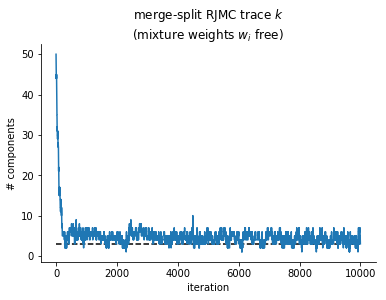

In [28]:
n_components_traj = [len(t[0]) / 3 for t in traj]
ax = plt.subplot(111)
plt.plot(n_components_traj)
plt.hlines(n_components, 0, len(traj), linestyles='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('# components')
plt.xlabel('iteration')
plt.title(r'merge-split RJMC trace $k$' + '\n(mixture weights ' + r'$w_i$ free)')
#plt.xscale('log')
plt.savefig('birth-death-n-components.jpg', dpi=300)

([], <a list of 0 Text yticklabel objects>)

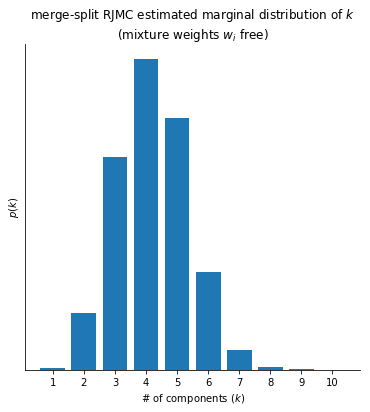

In [25]:
plt.figure(figsize=(6,6))

burned_in = n_components_traj[1000:]

n_components_range = sorted(list(set(burned_in)))
counts = np.bincount(burned_in)[1:]
ax = plt.subplot(111)

plt.bar(n_components_range, counts / sum(counts))
plt.xlabel(r'# of components ($k$)')
plt.ylabel(r'$p(k)$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'merge-split RJMC estimated marginal distribution of $k$' + '\n(mixture weights ' + r'$w_i$ free)')
plt.xticks(n_components_range)
plt.yticks([])

In [ ]:
log_posterior = np.array([flat_log_p(t[0]) for t in traj])
log_prior = np.array([log_prior(t[0]) for t in traj])
log_likelihood = log_posterior - log_prior

In [ ]:
plt.plot(log_prior, label='prior')
plt.plot(log_likelihood, label='likelihood')
plt.plot(log_posterior, label='posterior')
plt.legend(loc='best')
plt.ylabel('log probability')
plt.xlabel('iteration')
plt.xscale('log')

plt.savefig('birth-death-log-posterior.jpg', dpi=300)

In [ ]:
plt.hist(data, bins=50)

In [ ]:
# hmm that doesn't look so bad actually